<a href="https://colab.research.google.com/github/MariusMC8/Thesis-coding/blob/main/Risk_ranking_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas matplotlib

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib

In [3]:
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_ESP_1.json"
regions = gpd.read_file(url)

# Climate indicator: Hot Days above 35C (Climate-ADAPT)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Template storage data to analyse.csv to Template storage data to analyse.csv


In [ ]:
import os

old_name = "Template storage data to analyse.csv"
new_name = "Hot_days_35C.csv"

os.rename(old_name, new_name)

In [ ]:
data = pd.read_csv("Hot_days_35C.csv", sep=';', decimal=",", encoding='latin1')
data.head()

,ï»¿ID,Coordinates,Storage type,Region,Status,Power (MW),Capacity (MWh),Duration (hours),Importance score
0,Malpica Wind plus hybrid storage,"43.320000 , -8.810000",Battery,Galicia,Announced,7.75,15.5,2.00,2
1,BESS Sanxenxo,"42.409945, -8.808338",Battery,Galicia,Announced,5.00,20.0,4.00,2
2,Santiago-Jares,"42.390000 , -7.090000",Battery,Galicia,Operational,5.00,5.0,1.00,2
3,Conso,"42.250000 , -7.160000",PHS,Galicia,Operational,270.00,2280.0,8.44,3
4,Soutelo PSP,"42.150000 , -7.190000",PHS,Galicia,Operational,215.00,NaN,NaN,3


Fixing and cleaning data

In [ ]:
#Fix Storage ID name
data.columns = data.columns.str.replace('ï»¿', 'Storage')

#Identify region names
data.columns = data.columns.str.strip()
data["Region"].unique()

array(['Galicia', 'PrincipadodeAsturias', 'Cantabria', 'PaÃ\xadsVasco',
       'ComunidadForaldeNavarra', 'AragÃ³n', 'CataluÃ±a', 'IslasBaleares',
       'ComunidadValenciana', 'RegiÃ³ndeMurcia', 'AndalucÃ\xada',
       'CeutayMelilla', 'IslasCanarias', 'Extremadura', 'CastillayLeÃ³n',
       'Castilla-LaMancha'], dtype=object)

In [ ]:
#Fix region names
region_fix = {
    "PaÃ\xadsVasco": "PaísVasco",
    "AragÃ³n": "Aragón",
    "CataluÃ±a": "Cataluña",
    "RegiÃ³ndeMurcia": "RegióndeMurcia",
    "AndalucÃ\xada": "Andalucía",
    "CastillayLeÃ³n": "CastillayLeón"}

data["Region"] = data["Region"].replace(region_fix)

data["Region"].unique()

array(['Galicia', 'PrincipadodeAsturias', 'Cantabria', 'PaísVasco',
       'ComunidadForaldeNavarra', 'Aragón', 'Cataluña', 'IslasBaleares',
       'ComunidadValenciana', 'RegióndeMurcia', 'Andalucía',
       'CeutayMelilla', 'IslasCanarias', 'Extremadura', 'CastillayLeón',
       'Castilla-LaMancha'], dtype=object)

In [ ]:
# Remove BOM, whitespace, invisible characters
data['Storage type'] = (
    data['Storage type']
    .astype(str)
    .str.encode('utf-8', 'ignore')
    .str.decode('utf-8')
    .str.replace('\u200b', '', regex=False)  # zero-width space
    .str.replace('\xa0', ' ', regex=False)   # non-breaking space
    .str.strip()
)

In [ ]:
# Split coordinates into latitude and longitude
data[['lat','lon']] = data['Coordinates'].str.split(',', expand=True).astype(float)

In [ ]:
# Convert coordinates to geodataframe
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

Inputting data

In [ ]:
#Hot days above 35°C 1991-2020 for each region
hot_days_35_present_dict = {
    "Galicia": 0.4,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.02,
    "PaísVasco": 0.16,
    "ComunidadForaldeNavarra": 3.59,
    "LaRioja": 2.14,
    "Aragón": 6.82,
    "Cataluña": 2.14,
    "ComunidadValenciana": 3.04,
    "RegióndeMurcia": 5.8,
    "Andalucía": 17.13,
    "Castilla-LaMancha": 14.12,
    "CastillayLeón": 1.94,
    "ComunidaddeMadrid": 11.53,
    "Extremadura": 21.32,
    "IslasCanarias": 0.02,
    "IslasBaleares": 0.11,
    "CeutayMelilla": 2.47,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C 1991-2020"] = data["Region"].map(hot_days_35_present_dict)

In [ ]:
#Define bins for hazard strength
bins = [-float("inf"), 1, 5, 15, 25, 35, float("inf")]
labels = [0, 1, 2, 3, 4, 5]

data['Hot days >35C 1991-2020 hazard strength'] = pd.cut(
    data['Hot days >35C 1991-2020'].astype(float),
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
).astype(int)

In [ ]:
#Vulnerability score
vulnerability_hot_days_35 = {
    "Battery": 3,
    "PHS": 2,
    "Flywheel": 1
}

data["Vulnerability hot days >35C"] = data["Storage type"].map(vulnerability_hot_days_35)

In [ ]:
#Change in number of hot days above 35°C from 1991-2020 to 2011-2040 RCP4.5 for each region
hot_days_35_change45_dict = {
    "Galicia": 0.12,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.04,
    "PaísVasco": 0.23,
    "ComunidadForaldeNavarra": 1.55,
    "LaRioja": 1.09,
    "Aragón": 2.71,
    "Cataluña": 0.98,
    "ComunidadValenciana": 1.57,
    "RegióndeMurcia": 3.11,
    "Andalucía": 4.65,
    "Castilla-LaMancha": 5.65,
    "CastillayLeón": 1.61,
    "ComunidaddeMadrid": 4.85,
    "Extremadura": 5.95,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.13,
    "CeutayMelilla": 1.22,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C change RCP4.5"] = data["Region"].map(hot_days_35_change45_dict)

In [ ]:
#Change in number of hot days above 35°C from 1991-2020 to 2011-2040 RCP8.5 for each region
hot_days_35_change85_dict = {
    "Galicia": 0.11,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.04,
    "PaísVasco": 0.25,
    "ComunidadForaldeNavarra": 1.79,
    "LaRioja": 1.31,
    "Aragón": 3.20,
    "Cataluña": 1.10,
    "ComunidadValenciana": 1.95,
    "RegióndeMurcia": 3.78,
    "Andalucía": 6.63,
    "Castilla-LaMancha": 7.42,
    "CastillayLeón": 2.09,
    "ComunidaddeMadrid": 6.5,
    "Extremadura": 8.94,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.15,
    "CeutayMelilla": 1.29,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C change RCP8.5"] = data["Region"].map(hot_days_35_change85_dict)

In [ ]:
#Hot days above 35C 2011-2040 RCP4.5 for each region
hot_days_35_future45_dict = {
    "Galicia": 0.19,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.05,
    "PaísVasco": 0.38,
    "ComunidadForaldeNavarra": 4.83,
    "LaRioja": 2.99,
    "Aragón": 8.94,
    "Cataluña": 2.92,
    "ComunidadValenciana": 4.31,
    "RegióndeMurcia": 8.7,
    "Andalucía": 20.73,
    "Castilla-LaMancha": 18.91,
    "CastillayLeón": 3.58,
    "ComunidaddeMadrid": 16.52,
    "Extremadura": 26.69,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.26,
    "CeutayMelilla": 3.84,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C 2011-2040 RCP4.5"] = data["Region"].map(hot_days_35_future45_dict)

In [ ]:
#Define bins for future hazard strength RCP4.5
bins = [-float("inf"), 1, 5, 15, 25, 35, float("inf")]
labels = [0, 1, 2, 3, 4, 5]

data["Hot days >35C 2011-2040 hazard strength RCP4.5"] = pd.cut(
    data["Hot days >35C 2011-2040 RCP4.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [ ]:
#Hot days above 35C 2011-2040 RCP8.5 for each region
hot_days_35_future85_dict = {
    "Galicia": 0.18,
    "PrincipadodeAsturias": 0.0,
    "Cantabria": 0.05,
    "PaísVasco": 0.43,
    "ComunidadForaldeNavarra": 5.15,
    "LaRioja": 3.28,
    "Aragón": 9.53,
    "Cataluña": 3.09,
    "ComunidadValenciana": 4.76,
    "RegióndeMurcia": 9.26,
    "Andalucía": 22.75,
    "Castilla-LaMancha": 20.78,
    "CastillayLeón": 4.13,
    "ComunidaddeMadrid": 18.2,
    "Extremadura": 29.83,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.29,
    "CeutayMelilla": 3.97,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Hot days >35C 2011-2040 RCP8.5"] = data["Region"].map(hot_days_35_future85_dict)

In [ ]:
#Define bins for future hazard strength RCP8.5
bins = [-float("inf"), 1, 5, 15, 25, 35, float("inf")]
labels = [0, 1, 2, 3, 4, 5]

data["Hot days >35C 2011-2040 hazard strength RCP8.5"] = pd.cut(
    data["Hot days >35C 2011-2040 RCP8.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [ ]:
#Ensure numeric columns
cols_to_numeric = [
    'Hot days >35C 1991-2020 hazard strength',
    'Hot days >35C 2011-2040 hazard strength RCP4.5',
    'Hot days >35C 2011-2040 hazard strength RCP8.5',
    'Vulnerability hot days >35C',
    'Hot days >35C 1991-2020',
    'Hot days >35C 2011-2040 RCP4.5',
    'Hot days >35C 2011-2040 RCP8.5',
    'Hot days >35C change RCP4.5',
    'Hot days >35C change RCP8.5',
    'Importance score',
]
for col in cols_to_numeric:
    data[col] = pd.to_numeric(data[col], errors='coerce')

Mapping the data

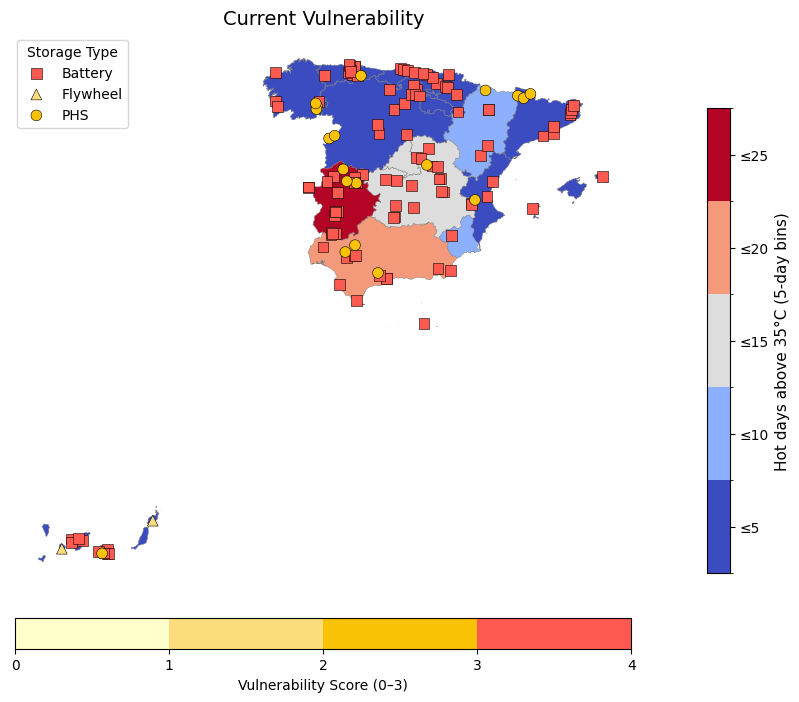

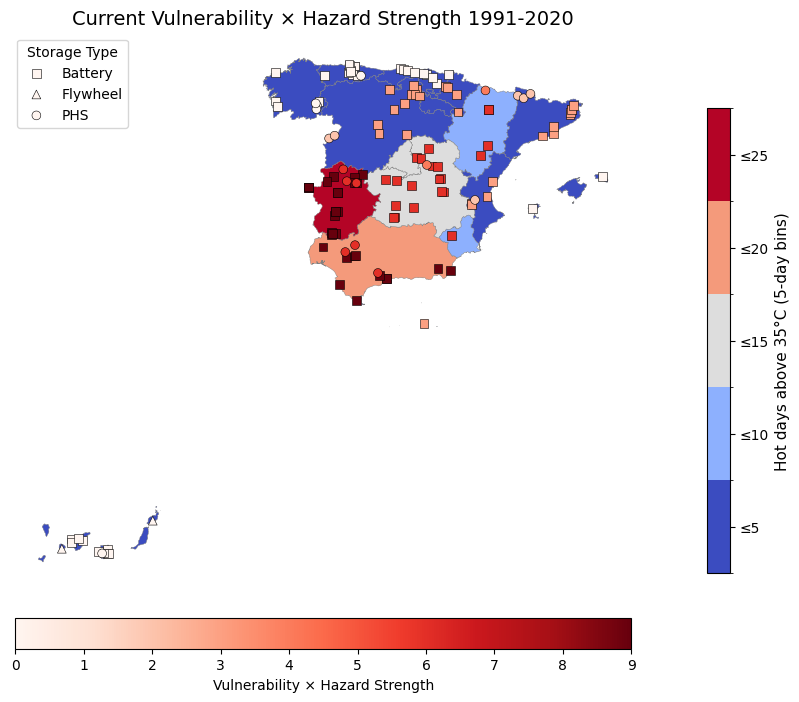

In [ ]:
#CURRENT VULNERABILITY

# =========================================================
# REGION-LEVEL BACKGROUND
# =========================================================

HOTDAYSCURRENT_COL = "Hot days >35C 1991-2020"

# -------------------------------
# 1. Bin function (define FIRST)
# -------------------------------
def apply_leq_bins(df, col):
    df = df.copy()

    bins = [0, 5, 10, 15, 20, 25, 30]
    labels = ["≤5", "≤10", "≤15", "≤20", "≤25", "≤30"]

    df[col + "_binned"] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=True
    )

    return df


# -------------------------------
# 2. Create region background ONLY from regions
# -------------------------------
regions_bg = regions.copy()

regions_bg[HOTDAYSCURRENT_COL] = regions_bg["NAME_1"].map(
    hot_days_35_present_dict
)

# -------------------------------
# 3. Apply binning to ALL regions
# -------------------------------
regions_bg = apply_leq_bins(regions_bg, HOTDAYSCURRENT_COL)


# =========================================================
# STRICT ≤ BINS FOR HOT DAYS >35C (0–5, 5–10, 10–15, 15–20, 20–25, 25–30)
# Upper bound INCLUDED (right=True)
# Labels: ≤5, ≤10, ≤15, ≤20, ≤25, ≤30
# =========================================================

def apply_leq_bins(df, col):
    df = df.copy()

    # Fixed bin edges (upper bound INCLUDED)
    bins = [0, 5, 10, 15, 20, 25, 30]

    labels = [
        "≤5",
        "≤10",
        "≤15",
        "≤20",
        "≤25",
        "≤30"
    ]

    # If values exceed 30 in future projections, extend bins
    vmax = df[col].max()
    if vmax > 30:
        # add 35, 40, ... until covering vmax
        extra_upper = int(((vmax // 5) + 1) * 5)
        bins.append(extra_upper)
        labels.append(f"≤{extra_upper}")

    df[col + "_binned"] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=True   # IMPORTANT → upper boundary INCLUDED
    )

    return df

# Ensure HOTDAYSCURRENT_COL and other necessary config variables are defined
REGION_COL = "Region"
ASSET_TYPE_COL = "Storage type"
VULN_COL = "Vulnerability hot days >35C"
HAZARDCURRENT_COL = "Hot days >35C 1991-2020 hazard strength"
HOTDAYSCURRENT_COL = "Hot days >35C 1991-2020"


# -------------------------------
# SAFE helper to get sorted category list for legend
# -------------------------------
def sorted_category_list(cat_series):
    # convert to strings, dropna, unique, try to sort by numeric if possible
    cats = [str(x) for x in pd.Series(cat_series.unique()).dropna()]
    try:
        # attempt to extract numeric start for ordering, fallback to lexicographic
        cats_sorted = sorted(cats, key=lambda s: float(s.replace('≤','').split('–')[0]))
    except Exception:
        cats_sorted = sorted(cats)
    return cats_sorted

# =========================================================
# DISCRETE VULNERABILITY COLOURS (0,1,2,3)
# =========================================================
vuln_colors = ["#FFFFCB", "#FBDD7E", "#FAC205", "#FC5A50"]
vuln_cmap = mcolors.ListedColormap(vuln_colors)
vuln_norm = mcolors.BoundaryNorm([0,1,2,3,4], vuln_cmap.N)


# -------------------------------
# Plotting functions using regions_bg
# -------------------------------
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

def plot_current_optionA(bg_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Use the pre-built regions_bg that contains the _binned column
    merged = regions_bg

    # Ensure the column exists on merged
    binned_col = bg_col + "_binned"
    if binned_col not in merged.columns:
        raise KeyError(f"{binned_col} not found in regions_bg — check you ran apply_leq_bins on data first")

    # categories present in the polygon GeoDataFrame (sorted)
    categories = sorted_category_list(merged[binned_col])

    # build discrete colormap
    cmap_bg = matplotlib.colormaps.get_cmap("coolwarm").resampled(len(categories)) # FIX: Use .resampled()
    bounds = np.arange(len(categories) + 1)
    norm_bg = mcolors.BoundaryNorm(bounds, cmap_bg.N)

    # Plot polygons (categorical)
    merged.plot(
        column=binned_col,
        cmap=cmap_bg,
        norm=norm_bg,
        ax=ax,
        edgecolor="grey",
        linewidth=0.3,
        legend=False
    )

    # Background colourbar
    sm = plt.cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=bounds[:-1] + 0.5, fraction=0.03, pad=0.02)
    cbar.set_ticklabels(categories)
    cbar.set_label("Hot days above 35°C (5-day bins)", fontsize=11)

    # Storage markers
    markers = {'Battery': 's', 'Flywheel': '^', 'PHS': 'o'}
    for t, marker in markers.items():
        subset = data[data[ASSET_TYPE_COL] == t]
        ax.scatter(
            subset["lon"], subset["lat"],
            c=subset[VULN_COL].astype(float),
            cmap=vuln_cmap,
            norm=vuln_norm,
            marker=marker,
            s=60,
            edgecolor="black",
            linewidth=0.4,
            label=t
        )

    # Vulnerability colourbar
    sm_v = plt.cm.ScalarMappable(cmap=vuln_cmap, norm=vuln_norm)
    plt.colorbar(sm_v, ax=ax, orientation="horizontal", fraction=0.05, pad=0.05).set_label("Vulnerability Score (0–3)")

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


def plot_current_optionB(bg_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    merged = regions_bg

    binned_col = bg_col + "_binned"
    if binned_col not in merged.columns:
        raise KeyError(f"{binned_col} not found in regions_bg — check you ran apply_leq_bins on data first")

    categories = sorted_category_list(merged[binned_col])

    cmap_bg = matplotlib.colormaps.get_cmap("coolwarm").resampled(len(categories)) # FIX: Use .resampled()
    bounds = np.arange(len(categories) + 1)
    norm_bg = mcolors.BoundaryNorm(bounds, cmap_bg.N)

    merged.plot(column=binned_col, cmap=cmap_bg, norm=norm_bg, ax=ax, edgecolor="grey", linewidth=0.3)

    sm = plt.cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=bounds[:-1] + 0.5, fraction=0.03, pad=0.02)
    cbar.set_ticklabels(categories)
    cbar.set_label("Hot days above 35°C (5-day bins)", fontsize=11)

    # compute VulnHazard_current if not already present
    if "VulnHazard_current" not in data.columns:
        data["VulnHazard_current"] = data[VULN_COL].astype(float) * data[HAZARDCURRENT_COL].astype(float)

    vals = data["VulnHazard_current"]
    norm_pts = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())

    markers = {"Battery": "s", "Flywheel": "^", "PHS": "o"}
    for t, marker in markers.items():
        subset = data[data[ASSET_TYPE_COL] == t]
        ax.scatter(
            subset["lon"], subset["lat"],
            c=subset["VulnHazard_current"].astype(float),
            cmap="Reds",
            norm=norm_pts,
            marker=marker,
            s=40,
            edgecolor="black",
            linewidth=0.4,
            label=t
        )

    sm_pts = plt.cm.ScalarMappable(cmap="Reds", norm=norm_pts)
    plt.colorbar(sm_pts, ax=ax, orientation="horizontal", fraction=0.05, pad=0.05).set_label("Vulnerability × Hazard Strength")

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()

plot_current_optionA(
    bg_col=HOTDAYSCURRENT_COL,
    title="Current Vulnerability"
)

plot_current_optionB(
    bg_col=HOTDAYSCURRENT_COL,
    title="Current Vulnerability × Hazard Strength 1991-2020"
)


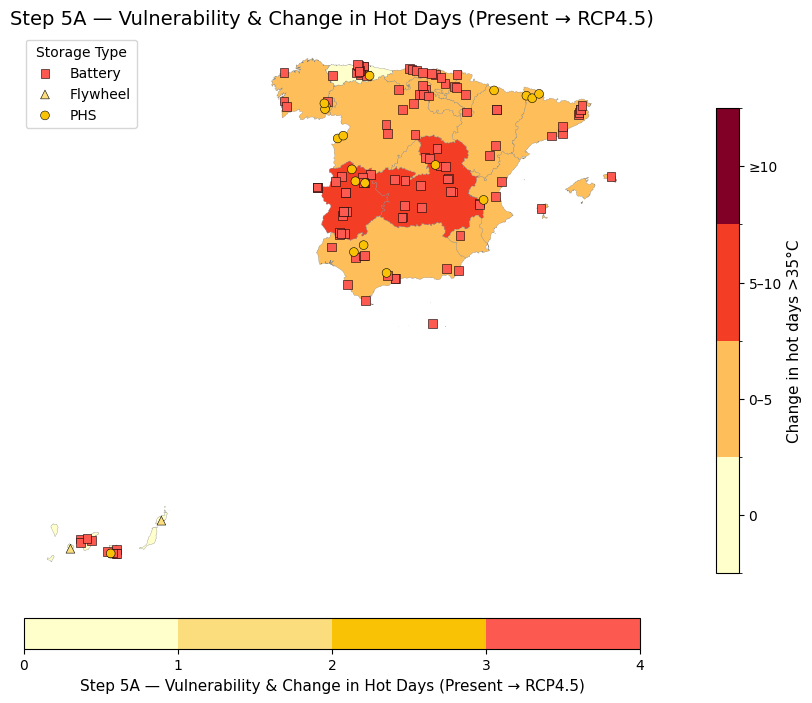

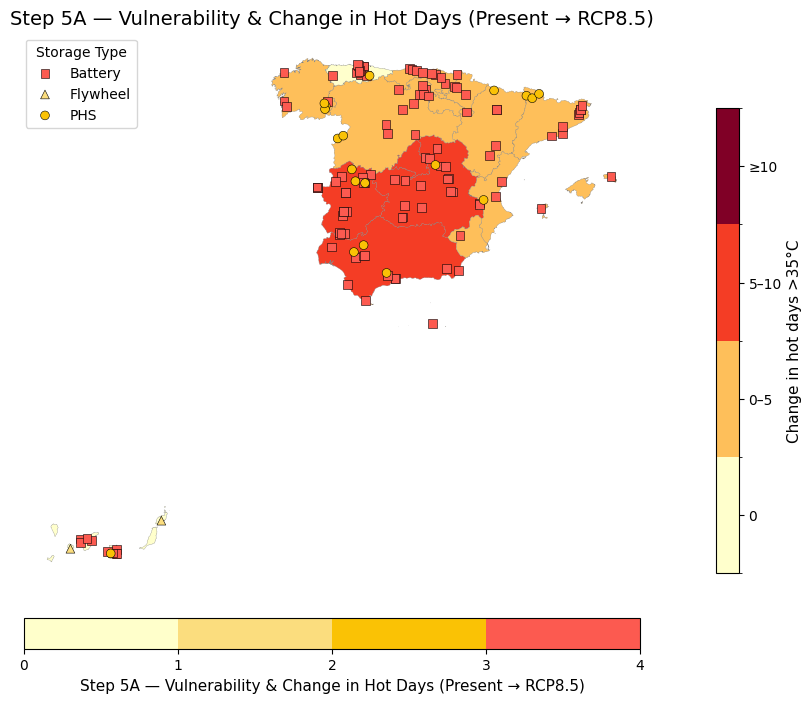

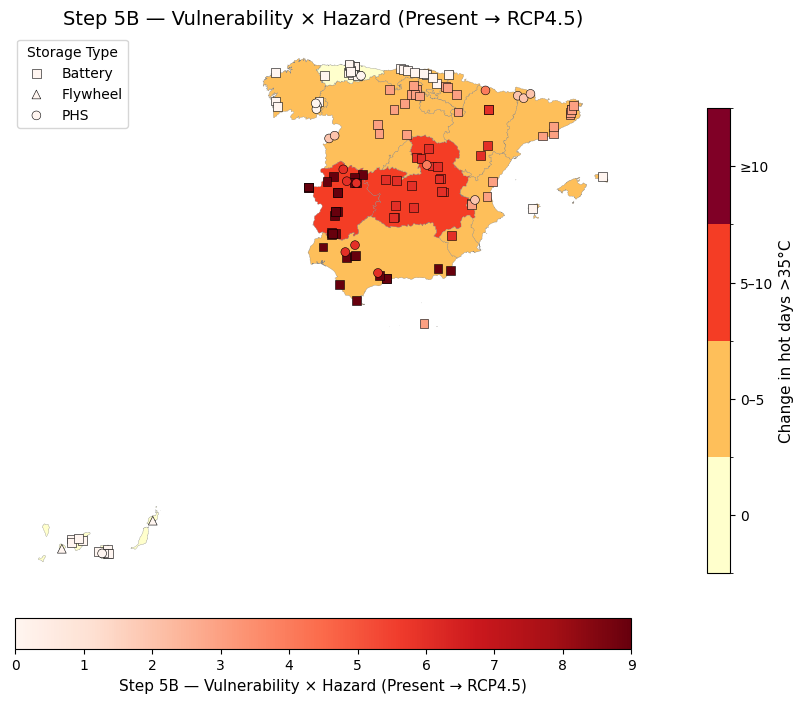

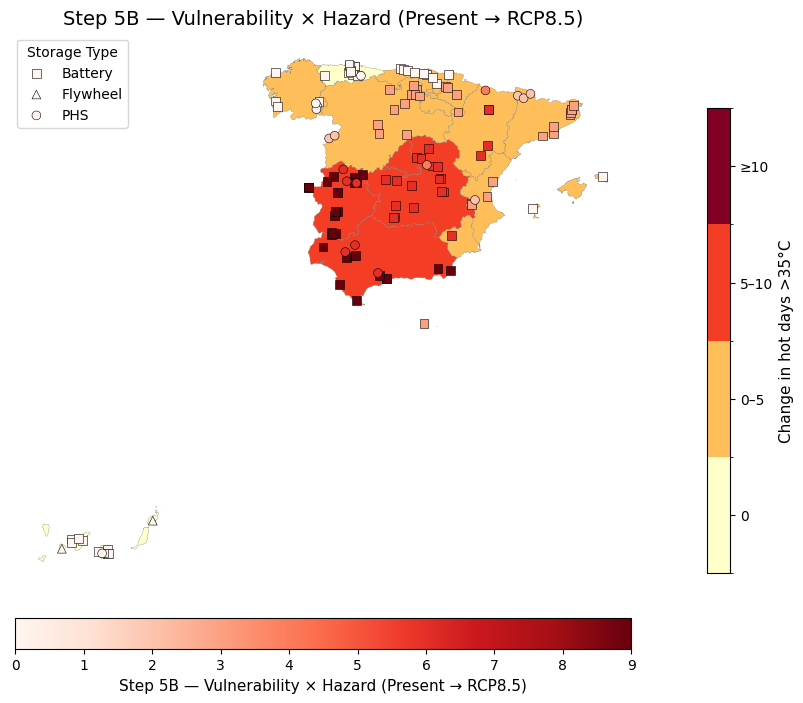

In [ ]:
# =========================================================
# ASSESSING POTENTIAL IMPACTS OF CLIMATE CHANGE  ON STORAGE PROJECTS (HOT DAYS >35C)
# =========================================================
# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
REGION_COL      = "Region"
ASSET_TYPE_COL  = "Storage type"
VULN_COL        = "Vulnerability hot days >35C"

HOTDAYS_CHANGE45 = "Hot days >35C change RCP4.5"
HOTDAYS_CHANGE85 = "Hot days >35C change RCP8.5"
HAZARDCURRENT_COL = "Hot days >35C 1991-2020 hazard strength"

# =========================================================
# REGION-LEVEL BACKGROUND
# =========================================================
# 1. Bin function (define FIRST)
change_bins = [-float("inf"), 0, 5, 10, float("inf")]
change_labels = ["0", "0–5", "5–10", "≥10"]

def bin_change(df, col):
    df[col + "_binned"] = pd.cut(
        df[col],
        bins=change_bins,
        labels=change_labels,
        include_lowest=True,
        right=True
    )
    return df

#Create region background from regions

regions_bg = regions.copy()

regions_bg[HOTDAYS_CHANGE45] = regions_bg["NAME_1"].map(
    hot_days_35_change45_dict
)
regions_bg[HOTDAYS_CHANGE85] = regions_bg["NAME_1"].map(
    hot_days_35_change85_dict
)

#Apply binning to ALL regions
regions_bg = bin_change(regions_bg, HOTDAYS_CHANGE45)
regions_bg = bin_change(regions_bg, HOTDAYS_CHANGE85)

# =========================================================
# 2. Colour map
# =========================================================
num_cats = len(change_labels)
import matplotlib
cmap_bg = matplotlib.colormaps.get_cmap("YlOrRd").resampled(num_cats)
norm_bg = mcolors.BoundaryNorm(np.arange(num_cats + 1), num_cats)


# =========================================================
# 3. Discrete vulnerability colormap (unchanged)
# =========================================================
vuln_colors = ["#FFFFCB", "#FBDD7E", "#FAC205", "#FC5A50"]
vuln_cmap = mcolors.ListedColormap(vuln_colors)
vuln_norm = mcolors.BoundaryNorm([0,1,2,3,4], vuln_cmap.N)


# =========================================================
# Function for both Option A & B
# =========================================================
def plot_step5(bg_col, title, color_points_by, cmap_points, norm_points):

    fig, ax = plt.subplots(figsize=(10, 8))

    merged = regions_bg

    # Plot background
    merged.plot(
        column=bg_col + "_binned",
        cmap=cmap_bg,
        norm=norm_bg,
        edgecolor="grey",
        linewidth=0.2,
        ax=ax,
        legend=False
    )

    # Colorbar for background
    sm_bg = plt.cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm_bg.set_array([])
    cbar = plt.colorbar(
        sm_bg, ax=ax,
        ticks=np.arange(num_cats) + 0.5,
        fraction=0.03, pad=0.02
    )
    cbar.set_ticklabels(change_labels)
    cbar.set_label("Change in hot days >35°C", fontsize=11)

    # Plot storage assets
    markers = {"Battery": "s", "Flywheel": "^", "PHS": "o"}

    for t, marker in markers.items():
        subset = data[data[ASSET_TYPE_COL] == t]
        ax.scatter(
            subset["lon"], subset["lat"],
            c=subset[color_points_by],
            cmap=cmap_points,
            norm=norm_points,
            marker=marker,
            s=40,
            edgecolor="black",
            linewidth=0.4,
            label=t
        )

    # Colorbar for points
    sm_pts = plt.cm.ScalarMappable(cmap=cmap_points, norm=norm_points)
    cbar2 = plt.colorbar(
        sm_pts, ax=ax, orientation="horizontal",
        fraction=0.05, pad=0.05
    )
    cbar2.set_label(title.split(":")[-1].strip(), fontsize=11)

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


# =========================================================
# 4. OPTION A — Vulnerability
# =========================================================
def plot_step5_optionA(bg_col, title):
    plot_step5(
        bg_col,
        title,
        color_points_by=VULN_COL,
        cmap_points=vuln_cmap,
        norm_points=vuln_norm
    )


# =========================================================
# 5. OPTION B — Vulnerability × HazardStrengthCurrent
# =========================================================
data["VulnHazard_current"] = (
    data[VULN_COL].astype(float) *
    data[HAZARDCURRENT_COL].astype(float)
)

def plot_step5_optionB(bg_col, title):
    vals = data["VulnHazard_current"]
    norm_pts = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())

    plot_step5(
        bg_col,
        title,
        color_points_by="VulnHazard_current",
        cmap_points="Reds",
        norm_points=norm_pts
    )


# =========================================================
# 6. GENERATE ALL MAPS
# =========================================================

plot_step5_optionA(
    HOTDAYS_CHANGE45,
    "Step 5A — Vulnerability & Change in Hot Days (Present → RCP4.5)"
)

plot_step5_optionA(
    HOTDAYS_CHANGE85,
    "Step 5A — Vulnerability & Change in Hot Days (Present → RCP8.5)"
)
#I don't think I need these
plot_step5_optionB(
    HOTDAYS_CHANGE45,
    "Step 5B — Vulnerability × Hazard (Present → RCP4.5)"
)

plot_step5_optionB(
    HOTDAYS_CHANGE85,
    "Step 5B — Vulnerability × Hazard (Present → RCP8.5)"
)


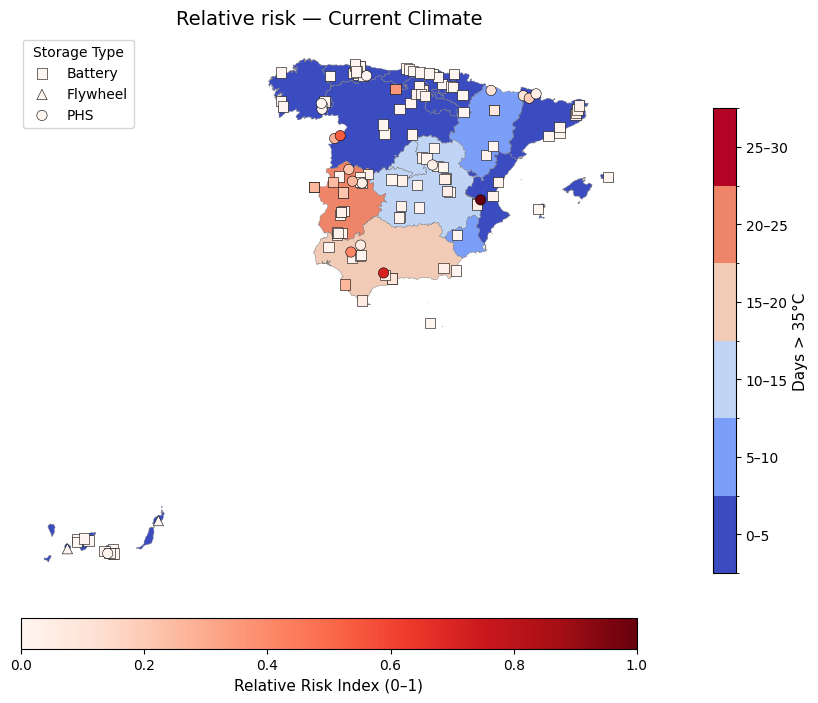

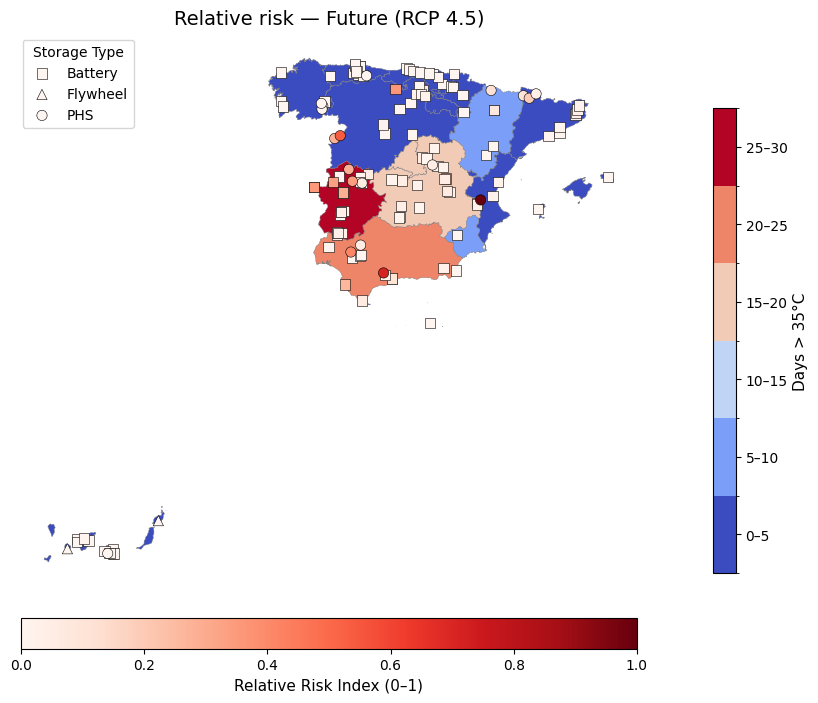

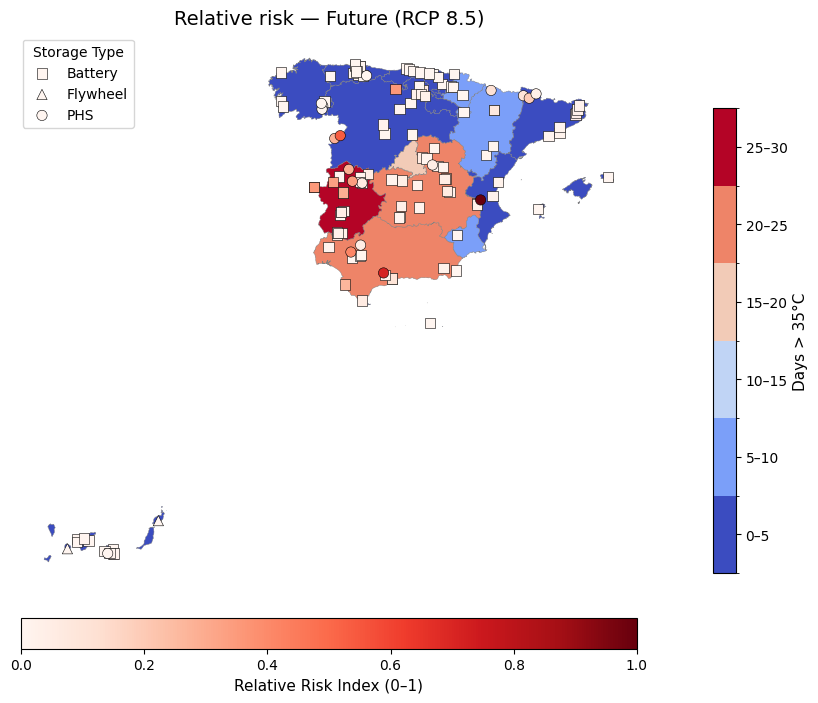

In [ ]:
#RELATIVE RISK
# =========================================================
# CONFIG
# =========================================================
REGION_COL = "Region"
ASSET_TYPE_COL = "Storage type"
CAPACITY_COL = "Capacity (MWh)"
POWER_COL = "Power (MW)"
IMPORTANCE_COL = "Importance score"
VULN_COL = "Vulnerability hot days >35C"

HAZARDCURRENT_COL = "Hot days >35C 1991-2020 hazard strength"
HAZARD45_COL     = "Hot days >35C 2011-2040 hazard strength RCP4.5"
HAZARD85_COL     = "Hot days >35C 2011-2040 hazard strength RCP8.5"

HOTDAYSCURRENT_COL = "Hot days >35C 1991-2020"
HOTDAYS45_COL      = "Hot days >35C 2011-2040 RCP4.5"
HOTDAYS85_COL      = "Hot days >35C 2011-2040 RCP8.5"

# =========================================================
# REGION-LEVEL BACKGROUND
# =========================================================
# 1. Bin function

bins = [0, 5, 10, 15, 20, 25, 30]
labels = ["0–5", "5–10", "10–15", "15–20", "20–25", "25–30"]

def apply_fixed_bins(df, col):
    df[col + "_binned"] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=False
    )
    return df

#Create region background from regions

regions_bg = regions.copy()

# Map current and future hot days data to regions_bg
regions_bg[HOTDAYSCURRENT_COL] = regions_bg["NAME_1"].map(
    hot_days_35_present_dict
)
regions_bg[HOTDAYS45_COL] = regions_bg["NAME_1"].map(
    hot_days_35_future45_dict
)
regions_bg[HOTDAYS85_COL] = regions_bg["NAME_1"].map(
    hot_days_35_future85_dict
)

#Apply binning to ALL regions
regions_bg = apply_fixed_bins(regions_bg, HOTDAYSCURRENT_COL)
regions_bg = apply_fixed_bins(regions_bg, HOTDAYS45_COL)
regions_bg = apply_fixed_bins(regions_bg, HOTDAYS85_COL)

# =========================================================
# 1. Choose exposure measure (MWh > MW > count)
# =========================================================
def choose_exposure(row):
    if pd.notna(row.get(CAPACITY_COL)):
        return float(row[CAPACITY_COL])
    if pd.notna(row.get(POWER_COL)):
        return float(row[POWER_COL])
    return 1.0

data["Exposure"] = data.apply(choose_exposure, axis=1)


# =========================================================
# 2. Compute raw risk per asset (IPCC: hazard × vulnerability × exposure)
# =========================================================
data["Riskcurrent_raw"] = (
    data[HAZARDCURRENT_COL].astype(float) *
    data[VULN_COL].astype(float) *
    data["Exposure"].astype(float)
)

data["Risk45_raw"] = (
    data[HAZARD45_COL].astype(float) *
    data[VULN_COL].astype(float) *
    data["Exposure"].astype(float)
)

data["Risk85_raw"] = (
    data[HAZARD85_COL].astype(float) *
    data[VULN_COL].astype(float) *
    data["Exposure"].astype(float)
)


# =========================================================
# 3. Normalise asset-level risks (0–1)
# =========================================================
def normalize(s):
    vmin, vmax = s.min(), s.max()
    if vmax == vmin:
        return pd.Series(0, index=s.index)
    return (s - vmin) / (vmax - vmin)

data["Riskcurrent_norm"] = normalize(data["Riskcurrent_raw"])
data["Risk45_norm"]      = normalize(data["Risk45_raw"])
data["Risk85_norm"]      = normalize(data["Risk85_raw"])


# =========================================================
# 4. REGIONAL risk index (sum of asset risks per region)
# =========================================================
region_risk = (
    data.groupby(REGION_COL)[["Riskcurrent_raw", "Risk45_raw", "Risk85_raw"]]
    .sum()
    .reset_index()
)

region_risk["Riskcurrent_region_norm"] = normalize(region_risk["Riskcurrent_raw"])
region_risk["Risk45_region_norm"]      = normalize(region_risk["Risk45_raw"])
region_risk["Risk85_region_norm"]      = normalize(region_risk["Risk85_raw"])


# =========================================================
# 5. Create GeoDataFrame for assets
# =========================================================
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["lon"], data["lat"]),
    crs="EPSG:4326"
)



# =========================================================
# 7. MAP FUNCTION (consistent colorbars + separate point risk)
# =========================================================

def plot_risk_map(bg_col, point_col, title):

    fig, ax = plt.subplots(figsize=(10, 8))

    # Merge background values with region polygons
    background = regions_bg

    # Background plot using binned hot days
    background.plot(
        column=bg_col + "_binned",
        cmap="coolwarm",
        linewidth=0.3,
        edgecolor="grey",
        ax=ax,
        legend=False
    )

    # --- Updated categorical colormap (NO deprecation warning) ---
    import matplotlib
    cmap_bg = matplotlib.colormaps.get_cmap("coolwarm").resampled(len(labels))

    norm_bg = mcolors.BoundaryNorm(
        boundaries=np.arange(0, len(labels) + 1),
        ncolors=len(labels)
    )

    sm_bg = cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm_bg.set_array([])

    cbar1 = fig.colorbar(
        sm_bg, ax=ax, fraction=0.03, pad=0.02, shrink=0.8,
        ticks=np.arange(len(labels)) + 0.5
    )
    cbar1.set_ticklabels(labels)
    cbar1.set_label("Days > 35°C", fontsize=11)

    # --- Points (asset relative risk) ---
    vals = points[point_col].astype(float)
    norm = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())

    markers = {"Battery": "s", "Flywheel": "^", "PHS": "o",}

    for stype, marker in markers.items():
        subset = points[points[ASSET_TYPE_COL] == stype]
        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            c=subset[point_col],
            cmap="Reds",
            norm=norm,
            marker=marker,
            s=55,
            edgecolor="black",
            linewidth=0.4,
            zorder=5,
            label=stype
        )

    # Point colorbar
    sm_pts = cm.ScalarMappable(cmap="Reds", norm=norm)
    fig.colorbar(sm_pts, ax=ax, orientation="horizontal",
                 fraction=0.05, pad=0.05
    ).set_label("Relative Risk Index (0–1)", fontsize=11)

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()



# =========================================================
# 8. GENERATE MAPS
# =========================================================

# Current climate
plot_risk_map(
    bg_col=HOTDAYSCURRENT_COL,
    point_col="Riskcurrent_norm",
    title="Relative risk — Current Climate"
)

# RCP4.5
plot_risk_map(
    bg_col=HOTDAYS45_COL,
    point_col="Risk45_norm",
    title="Relative risk — Future (RCP 4.5)"
)

# RCP8.5
plot_risk_map(
    bg_col=HOTDAYS85_COL,
    point_col="Risk85_norm",
    title="Relative risk — Future (RCP 8.5)"
)


/tmp/ipython-input-4275643216.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


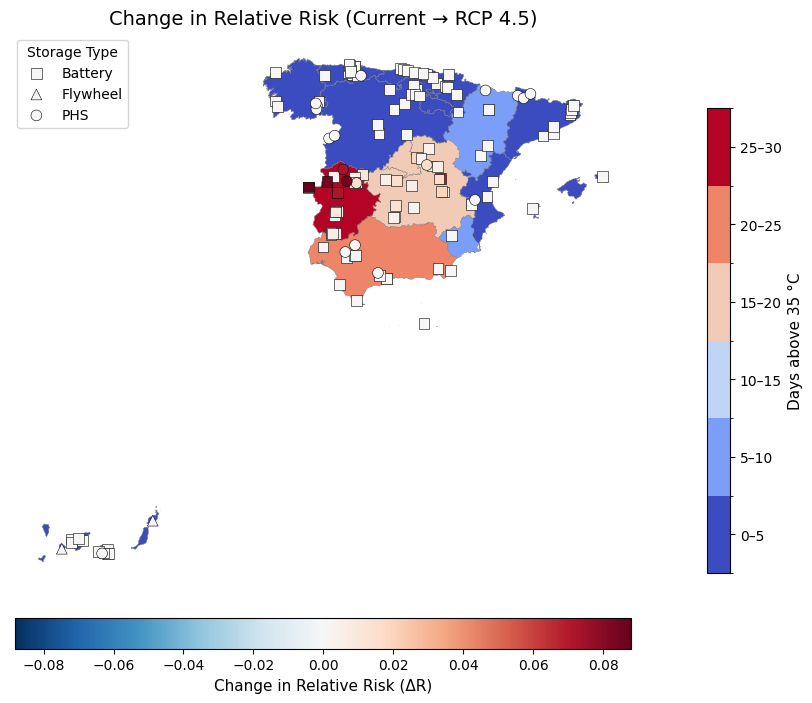

/tmp/ipython-input-4275643216.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


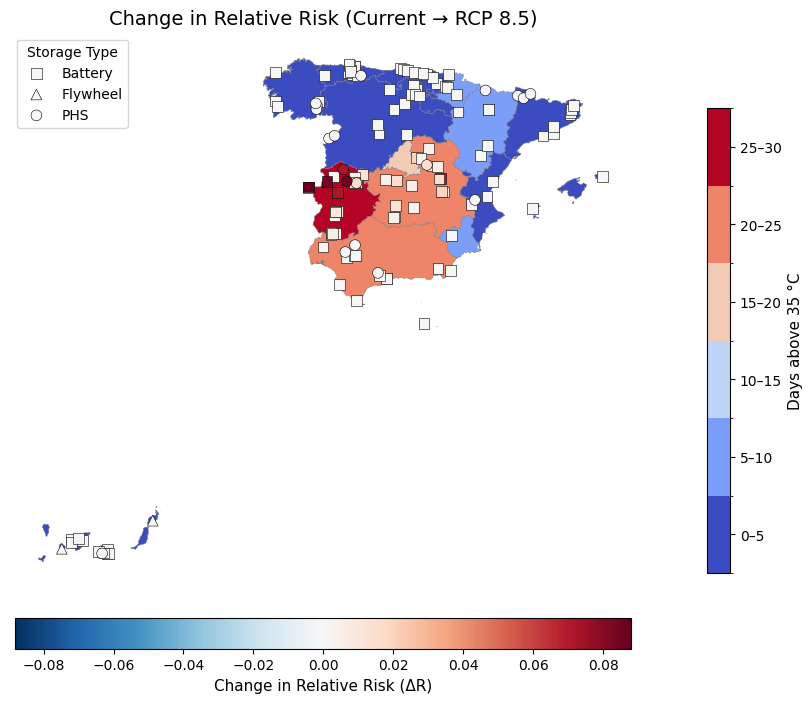

/tmp/ipython-input-4275643216.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


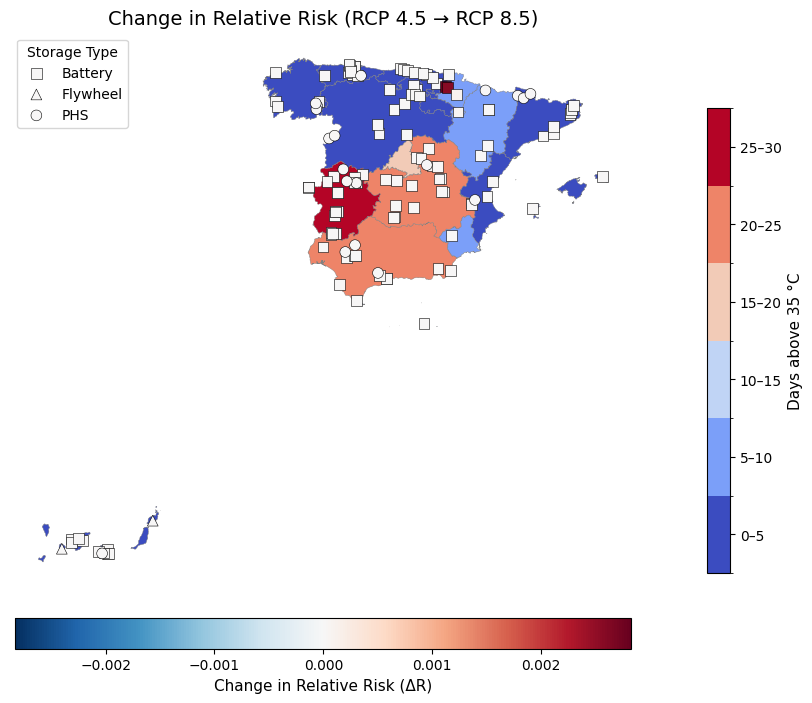

In [ ]:
#CHANGES IN RELATIVE RISK
# =========================================================
# 1. COMPUTE DIFFERENCES BETWEEN SCENARIOS
# =========================================================

points["Delta_current_45"] = points["Risk45_norm"] - points["Riskcurrent_norm"]
points["Delta_current_85"] = points["Risk85_norm"] - points["Riskcurrent_norm"]
points["Delta_45_85"]      = points["Risk85_norm"] - points["Risk45_norm"]

# =========================================================
# REGION-LEVEL BACKGROUND
# =========================================================
# 1. Bin function

bins = [0, 5, 10, 15, 20, 25, 30]
labels = ["0–5", "5–10", "10–15", "15–20", "20–25", "25–30"]

def apply_fixed_bins(df, col):
    df[col + "_binned"] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=False
    )
    return df

#Create region background from regions

regions_bg = regions.copy()

# Map current and future hot days data to regions_bg
regions_bg[HOTDAYSCURRENT_COL] = regions_bg["NAME_1"].map(
    hot_days_35_present_dict
)
regions_bg[HOTDAYS45_COL] = regions_bg["NAME_1"].map(
    hot_days_35_future45_dict
)
regions_bg[HOTDAYS85_COL] = regions_bg["NAME_1"].map(
    hot_days_35_future85_dict
)

#Apply binning to ALL regions
regions_bg = apply_fixed_bins(regions_bg, HOTDAYS45_COL)
regions_bg = apply_fixed_bins(regions_bg, HOTDAYS85_COL)

# =========================================================
# 2. NEW PLOT FUNCTION FOR CHANGE MAPS (diverging colours)
# =========================================================

def plot_change_map(bg_col, delta_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Background layer (same hot-day bins)
    background = regions_bg

    background.plot(
        column=bg_col + "_binned",
        cmap="coolwarm",
        linewidth=0.3,
        edgecolor="grey",
        ax=ax,
        legend=False
    )

    # Background colorbar (same bins for all maps)
    labels = ["0–5","5–10","10–15","15–20","20–25","25–30"]
    cmap_bg = cm.get_cmap("coolwarm", len(labels))
    norm_bg = mcolors.BoundaryNorm(range(len(labels)+1), cmap_bg.N)

    sm_bg = cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm_bg.set_array([])

    cbar1 = fig.colorbar(
        sm_bg, ax=ax, fraction=0.03, pad=0.02, shrink=0.8,
        ticks=np.arange(len(labels)) + 0.5
    )
    cbar1.set_ticklabels(labels)
    cbar1.set_label("Days above 35 °C", fontsize=11)

    # ---------------------------------------
    # POINTS (risk change: diverging colormap)
    vals = points[delta_col].astype(float)
    absmax = max(abs(vals.min()), abs(vals.max()))
    norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-absmax, vmax=absmax)

    for stype, marker in {"Battery":"s","Flywheel":"^", "PHS": "o",}.items():
        subset = points[points[ASSET_TYPE_COL] == stype]

        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            c=subset[delta_col],
            cmap="RdBu_r",
            norm=norm,
            marker=marker,
            s=60,
            edgecolor="black",
            linewidth=0.4,
            zorder=5,
            label=stype
        )

    # Point colorbar (risk change)
    sm_pts = cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    cbar2 = fig.colorbar(
        sm_pts, ax=ax, orientation="horizontal",
        fraction=0.05, pad=0.05
    )
    cbar2.set_label("Change in Relative Risk (ΔR)", fontsize=11)

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


# =========================================================
# 3. PLOT CHANGE MAPS
# =========================================================

# Current → RCP4.5
plot_change_map(
    bg_col=HOTDAYS45_COL,
    delta_col="Delta_current_45",
    title="Change in Relative Risk (Current → RCP 4.5)"
)

# Current → RCP8.5
plot_change_map(
    bg_col=HOTDAYS85_COL,
    delta_col="Delta_current_85",
    title="Change in Relative Risk (Current → RCP 8.5)"
)

# RCP4.5 → RCP8.5
plot_change_map(
    bg_col=HOTDAYS85_COL,
    delta_col="Delta_45_85",
    title="Change in Relative Risk (RCP 4.5 → RCP 8.5)"
)


/tmp/ipython-input-2375170131.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


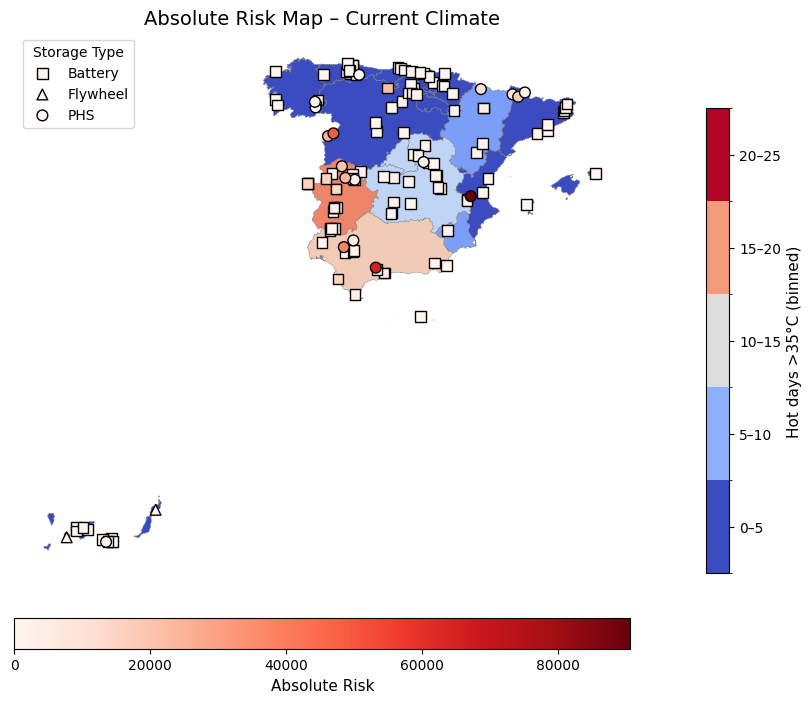

/tmp/ipython-input-2375170131.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


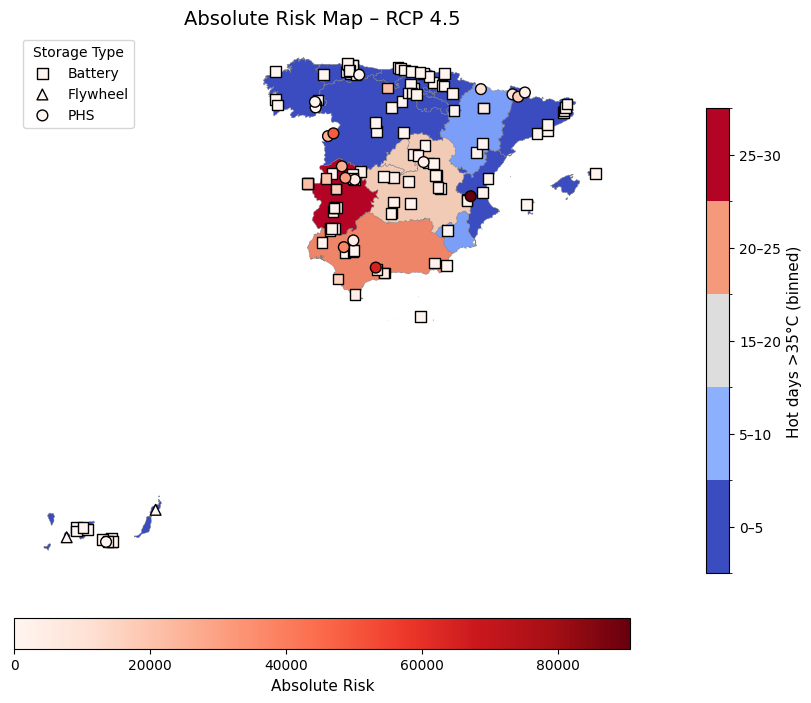

/tmp/ipython-input-2375170131.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


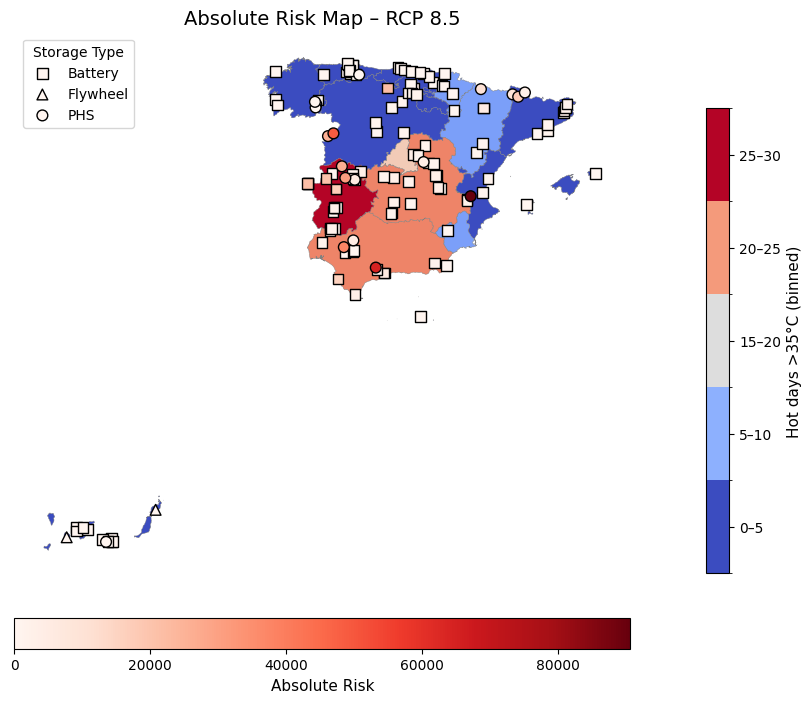

/tmp/ipython-input-2375170131.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


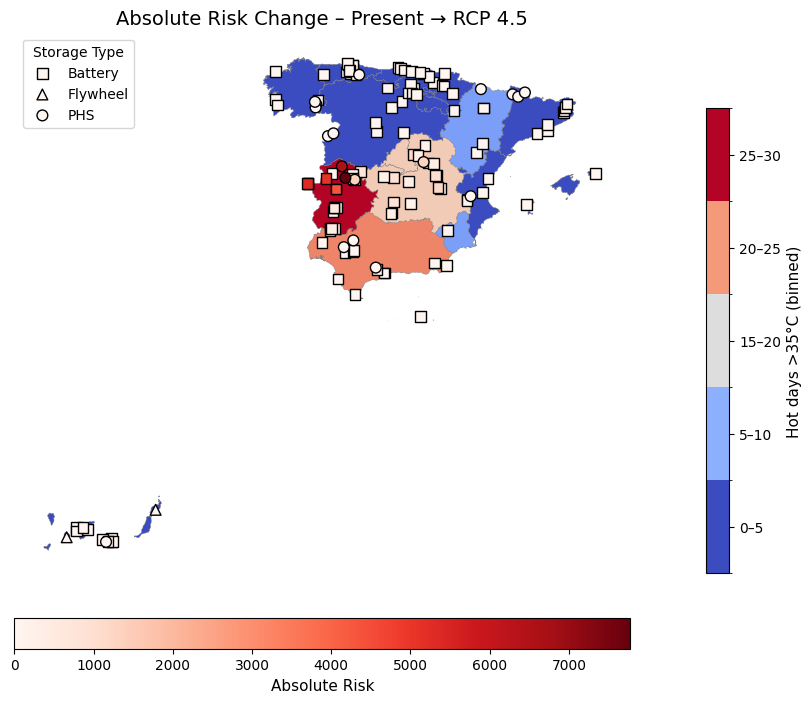

/tmp/ipython-input-2375170131.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


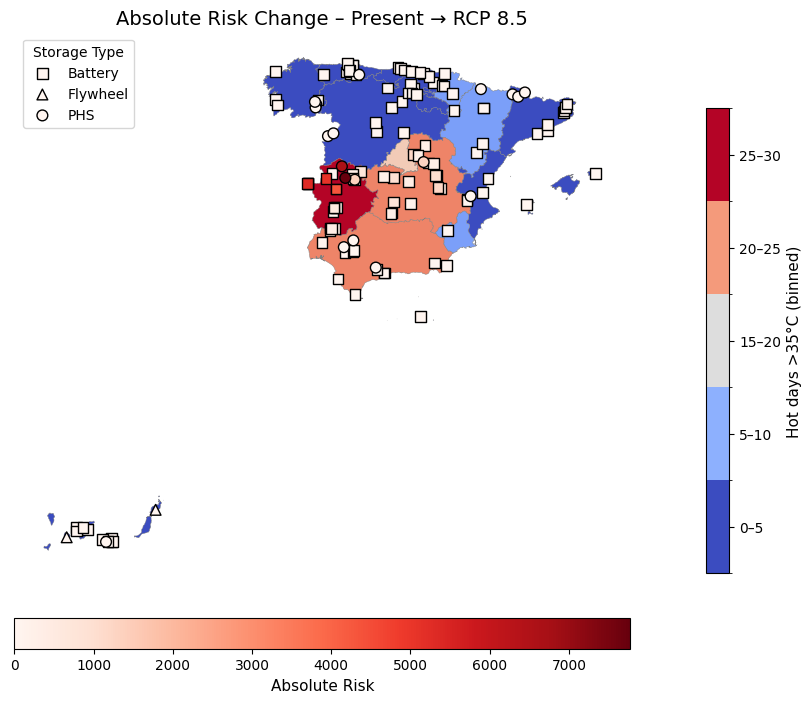

In [ ]:
#ABSOLUTE RISK MAPS
# ============================================
# CONFIG
# ============================================
REGION_COL = "Region"
TYPE_COL = "Storage type"
CAPACITY_COL = "Capacity (MWh)"
POWER_COL = "Power (MW)"
IMPORTANCE_COL = "Importance score"
VULN_COL = "Vulnerability hot days >35C"

HAZ_CUR = "Hot days >35C 1991-2020 hazard strength"
HAZ_45 = "Hot days >35C 2011-2040 hazard strength RCP4.5"
HAZ_85 = "Hot days >35C 2011-2040 hazard strength RCP8.5"

HOT_CUR = "Hot days >35C 1991-2020"
HOT_45 = "Hot days >35C 2011-2040 RCP4.5"
HOT_85 = "Hot days >35C 2011-2040 RCP8.5"

# =========================================================
# REGION-LEVEL BACKGROUND
# =========================================================
# 1. Bin function

bins = [0, 5, 10, 15, 20, 25, 30]
labels = ["0–5", "5–10", "10–15", "15–20", "20–25", "25–30"]

def apply_fixed_bins(df, col):
    df[col + "_binned"] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=False
    )
    return df

#Create region background from regions

regions_bg = regions.copy()

# Map current and future hot days data to regions_bg
regions_bg[HOTDAYSCURRENT_COL] = regions_bg["NAME_1"].map(
    hot_days_35_present_dict
)
regions_bg[HOTDAYS45_COL] = regions_bg["NAME_1"].map(
    hot_days_35_future45_dict
)
regions_bg[HOTDAYS85_COL] = regions_bg["NAME_1"].map(
    hot_days_35_future85_dict
)

#Apply binning to ALL regions
regions_bg = apply_fixed_bins(regions_bg, HOTDAYSCURRENT_COL)
regions_bg = apply_fixed_bins(regions_bg, HOTDAYS45_COL)
regions_bg = apply_fixed_bins(regions_bg, HOTDAYS85_COL)

# ============================================
# 1. EXPOSURE SELECTION (MWh > MW > 1)
# ============================================
def choose_exposure(row):
    if pd.notna(row.get(CAPACITY_COL)):
        return float(row[CAPACITY_COL])
    if pd.notna(row.get(POWER_COL)):
        return float(row[POWER_COL])
    return 1.0

data["Exposure"] = data.apply(choose_exposure, axis=1)

# ============================================
# 2. ABSOLUTE RISK CALCULATION
# ============================================
# Risk = Hazard × Vulnerability × Exposure × Importance

data["Risk_current_abs"] = (
    data[HAZ_CUR].astype(float)
    * data[VULN_COL].astype(float)
    * data["Exposure"].astype(float)
    * data[IMPORTANCE_COL].astype(float)
)

data["Risk_45_abs"] = (
    data[HAZ_45].astype(float)
    * data[VULN_COL].astype(float)
    * data["Exposure"].astype(float)
    * data[IMPORTANCE_COL].astype(float)
)

data["Risk_85_abs"] = (
    data[HAZ_85].astype(float)
    * data[VULN_COL].astype(float)
    * data["Exposure"].astype(float)
    * data[IMPORTANCE_COL].astype(float)
)

# ============================================
# 3. ABSOLUTE RISK CHANGE
# ============================================
data["Risk_change_45"] = data["Risk_45_abs"] - data["Risk_current_abs"]
data["Risk_change_85"] = data["Risk_85_abs"] - data["Risk_current_abs"]

# ============================================
# 4. Create GeoDataFrame for POINTS
# ============================================
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["lon"], data["lat"]),
    crs="EPSG:4326"
)

# ============================================
# 5. BINNING HOT DAYS (for consistent background)
# ============================================
def bin_hot_days(df, col):
    bins = [0, 5, 10, 15, 20, 25, 30, np.inf]
    labels = ["0–4", "5–9", "10–14", "15–19", "20–24", "25–29", "30+"]
    df[col + "_binned"] = pd.cut(df[col], bins=bins, labels=labels, right=False)
    return df

for col in [HOT_CUR, HOT_45, HOT_85]:
    data = bin_hot_days(data, col)

# ============================================
# 6. PLOTTING FUNCTION FOR ABSOLUTE RISK MAPS
# ============================================
def plot_absolute_risk(bg_col, risk_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # ---- Background map using HOT-DAY bins ----
    background = regions_bg

    background.plot(
        column=bg_col + "_binned",
        cmap="coolwarm",
        linewidth=0.3,
        edgecolor="grey",
        ax=ax,
        legend=False
    )

    # Custom legend for background bins
    categories = regions_bg[bg_col + "_binned"].dropna().unique().tolist()
    categories.sort(key=lambda c: float(c.split("–")[0]) if "–" in c else 99)
    cmap_bg = cm.get_cmap("coolwarm", len(categories))
    sm_bg = cm.ScalarMappable(
        cmap=cmap_bg,
        norm=mcolors.BoundaryNorm(range(len(categories)+1), cmap_bg.N)
    )
    cbar1 = fig.colorbar(sm_bg, ax=ax, fraction=0.03, pad=0.02, shrink=0.8)
    cbar1.set_ticks(np.arange(len(categories)) + 0.5)
    cbar1.set_ticklabels(categories)
    cbar1.set_label("Hot days >35°C (binned)", fontsize=11)

    # ---- Storage projects ----
    vals = points[risk_col].astype(float)
    norm = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())

    markers = {"Battery": "s", "Flywheel": "^", "PHS": "o",}

    for t, marker in markers.items():
        subset = points[points[TYPE_COL] == t]
        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            c=subset[risk_col],
            cmap="Reds",
            norm=norm,
            marker=marker,
            s=60,
            edgecolor="black",
            zorder=5,
            label=t
        )

    sm_risk = cm.ScalarMappable(norm=norm, cmap="Reds")
    cbar2 = fig.colorbar(
        sm_risk, ax=ax, orientation="horizontal",
        fraction=0.05, pad=0.07
    )
    cbar2.set_label("Absolute Risk", fontsize=11)

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


# ============================================
# 7. PLOT ABSOLUTE RISK MAPS
# ============================================

# ---- CURRENT ----
plot_absolute_risk(
    bg_col=HOT_CUR,
    risk_col="Risk_current_abs",
    title="Absolute Risk Map – Current Climate"
)

# ---- RCP 4.5 ----
plot_absolute_risk(
    bg_col=HOT_45,
    risk_col="Risk_45_abs",
    title="Absolute Risk Map – RCP 4.5"
)

# ---- RCP 8.5 ----
plot_absolute_risk(
    bg_col=HOT_85,
    risk_col="Risk_85_abs",
    title="Absolute Risk Map – RCP 8.5"
)

# ============================================
# 8. MAP RISK CHANGES
# ============================================

# ---- Change Present → RCP 4.5 ----
plot_absolute_risk(
    bg_col=HOT_45,
    risk_col="Risk_change_45",
    title="Absolute Risk Change – Present → RCP 4.5"
)

# ---- Change Present → RCP 8.5 ----
plot_absolute_risk(
    bg_col=HOT_85,
    risk_col="Risk_change_85",
    title="Absolute Risk Change – Present → RCP 8.5"
)


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

data


,StorageID,Coordinates,Storage type,Region,Status,Power (MW),Capacity (MWh),Duration (hours),Importance score,lat,lon,Hot days >35C 1991-2020,Hot days >35C 1991-2020 hazard strength,Vulnerability hot days >35C,Hot days >35C change RCP4.5,Hot days >35C change RCP8.5,Hot days >35C 2011-2040 RCP4.5,Hot days >35C 2011-2040 hazard strength RCP4.5,Hot days >35C 2011-2040 RCP8.5,Hot days >35C 2011-2040 hazard strength RCP8.5,Hot days >35C 1991-2020_binned,VulnHazard_current
0,Malpica Wind plus hybrid storage,"43.320000 , -8.810000",Battery,Galicia,Announced,7.75,15.50,2.00,2,43.320000,-8.810000,0.40,0,3,0.12,0.11,0.19,0,0.18,0,≤5,0.0
1,BESS Sanxenxo,"42.409945, -8.808338",Battery,Galicia,Announced,5.00,20.00,4.00,2,42.409945,-8.808338,0.40,0,3,0.12,0.11,0.19,0,0.18,0,≤5,0.0
2,Santiago-Jares,"42.390000 , -7.090000",Battery,Galicia,Operational,5.00,5.00,1.00,2,42.390000,-7.090000,0.40,0,3,0.12,0.11,0.19,0,0.18,0,≤5,0.0
3,Conso,"42.250000 , -7.160000",PHS,Galicia,Operational,270.00,2280.00,8.44,3,42.250000,-7.160000,0.40,0,2,0.12,0.11,0.19,0,0.18,0,≤5,0.0
4,Soutelo PSP,"42.150000 , -7.190000",PHS,Galicia,Operational,215.00,NaN,NaN,3,42.150000,-7.190000,0.40,0,2,0.12,0.11,0.19,0,0.18,0,≤5,0.0
5,Puente Bibey,"42.334200, -7.215200",PHS,Galicia,Operational,263.00,NaN,NaN,3,42.334200,-7.215200,0.40,0,2,0.12,0.11,0.19,0,0.18,0,≤5,0.0
6,BESS Troncal (Vigo),"42.23282, -8.72264",Battery,Galicia,Announced,160.00,342.00,NaN,2,42.232820,-8.722640,0.40,0,3,0.12,0.11,0.19,0,0.18,0,≤5,0.0
7,ST Grandas de Salime,"43.220000 , -6.880000",Battery,PrincipadodeAsturias,Announced,200.00,800.00,4.00,2,43.220000,-6.880000,0.00,0,3,0.00,0.00,0.00,0,0.00,0,≤5,0.0
8,BESS MIERES,"43.250000 , -5.780000",Battery,PrincipadodeAsturias,Announced,12.00,46.00,4.10,2,43.250000,-5.780000,0.00,0,3,0.00,0.00,0.00,0,0.00,0,≤5,0.0
9,Raitan ST1,"43.313387 , -5.941920",Battery,PrincipadodeAsturias,Announced,15.00,60.00,4.00,2,43.313387,-5.941920,0.00,0,3,0.00,0.00,0.00,0,0.00,0,≤5,0.0


# Frost days

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Template storage data to analyse.csv to Template storage data to analyse.csv


In [5]:
import os

old_name = "Template storage data to analyse.csv"
new_name = "Frost days.csv"

os.rename(old_name, new_name)

In [6]:
data = pd.read_csv("Frost days.csv", sep=';', decimal=",", encoding='latin1')
data.head()

,ï»¿ID,Coordinates,Storage type,Region,Status,Power (MW),Capacity (MWh),Duration (hours),Importance score
0,Malpica Wind plus hybrid storage,"43.320000 , -8.810000",Battery,Galicia,Announced,7.75,15.5,2.00,2
1,BESS Sanxenxo,"42.409945, -8.808338",Battery,Galicia,Announced,5.00,20.0,4.00,2
2,Santiago-Jares,"42.390000 , -7.090000",Battery,Galicia,Operational,5.00,5.0,1.00,2
3,Conso,"42.250000 , -7.160000",PHS,Galicia,Operational,270.00,2280.0,8.44,3
4,Soutelo PSP,"42.150000 , -7.190000",PHS,Galicia,Operational,215.00,NaN,NaN,3


Fixing and data cleaning

In [7]:
#Fix Storage ID name
data.columns = data.columns.str.replace('ï»¿', 'Storage')

#Identify region names
data.columns = data.columns.str.strip()
data["Region"].unique()

array(['Galicia', 'PrincipadodeAsturias', 'Cantabria', 'PaÃ\xadsVasco',
       'ComunidadForaldeNavarra', 'AragÃ³n', 'CataluÃ±a', 'IslasBaleares',
       'ComunidadValenciana', 'RegiÃ³ndeMurcia', 'AndalucÃ\xada',
       'CeutayMelilla', 'IslasCanarias', 'Extremadura', 'CastillayLeÃ³n',
       'Castilla-LaMancha'], dtype=object)

In [8]:
#Fix region names
region_fix = {
    "PaÃ\xadsVasco": "PaísVasco",
    "AragÃ³n": "Aragón",
    "CataluÃ±a": "Cataluña",
    "RegiÃ³ndeMurcia": "RegióndeMurcia",
    "AndalucÃ\xada": "Andalucía",
    "CastillayLeÃ³n": "CastillayLeón"}

data["Region"] = data["Region"].replace(region_fix)

data["Region"].unique()

array(['Galicia', 'PrincipadodeAsturias', 'Cantabria', 'PaísVasco',
       'ComunidadForaldeNavarra', 'Aragón', 'Cataluña', 'IslasBaleares',
       'ComunidadValenciana', 'RegióndeMurcia', 'Andalucía',
       'CeutayMelilla', 'IslasCanarias', 'Extremadura', 'CastillayLeón',
       'Castilla-LaMancha'], dtype=object)

In [9]:
# Remove BOM, whitespace, invisible characters
data['Storage type'] = (
    data['Storage type']
    .astype(str)
    .str.encode('utf-8', 'ignore')
    .str.decode('utf-8')
    .str.replace('\u200b', '', regex=False)  # zero-width space
    .str.replace('\xa0', ' ', regex=False)   # non-breaking space
    .str.strip()
)

In [10]:
# Split coordinates into latitude and longitude
data[['lat','lon']] = data['Coordinates'].str.split(',', expand=True).astype(float)

In [11]:
# Convert coordinates to geodataframe
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

Inputting data

In [13]:
#Frost days 1991-2020 for each region
frost_days_present_dict = {
    "Galicia": 13.6,
    "PrincipadodeAsturias": 21.41,
    "Cantabria": 19.7,
    "PaísVasco": 14.4,
    "ComunidadForaldeNavarra": 27.84,
    "LaRioja": 40.51,
    "Aragón": 47.51,
    "Cataluña": 42.84,
    "ComunidadValenciana": 14.59,
    "RegióndeMurcia": 8.83,
    "Andalucía": 9.39,
    "Castilla-LaMancha": 29.95,
    "CastillayLeón": 40.87,
    "ComunidaddeMadrid": 36.81,
    "Extremadura": 8.99,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.0,
    "CeutayMelilla": 0.0,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Frost days 1991-2020"] = data["Region"].map(frost_days_present_dict)

In [29]:
#Define bins for hazard strength
bins = [-float("inf"), 1, 15, 30, 45, 60, float("inf")]
labels = [0, 1, 2, 3, 4, 5]

data['Frost days 1991-2020 hazard strength'] = pd.cut(
    data['Frost days 1991-2020'].astype(float),
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
).astype(int)

In [26]:
#Vulnerability score
vulnerability_frost_days = {
    "Battery": 2,
    "PHS": 1,
    "Flywheel": 1
}

data["Vulnerability frost days"] = data["Storage type"].map(vulnerability_hot_days_35)

In [17]:
#Change in number of frost days from 1991-2020 to 2011-2040 RCP4.5 for each region
frost_days_change45_dict = {
    "Galicia": -2.5,
    "PrincipadodeAsturias": -4.4,
    "Cantabria": -3.98,
    "PaísVasco": -3.27,
    "ComunidadForaldeNavarra": -5.52,
    "LaRioja": -6.91,
    "Aragón": -6.44,
    "Cataluña": -4.77,
    "ComunidadValenciana": -2.54,
    "RegióndeMurcia": -1.77,
    "Andalucía": -1.66,
    "Castilla-LaMancha": -4.41,
    "CastillayLeón": -6.55,
    "ComunidaddeMadrid": -5.39,
    "Extremadura": -1.73,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.0,
    "CeutayMelilla": 0.0,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Frost days change RCP4.5"] = data["Region"].map(frost_days_change45_dict)

In [18]:
#Change in number of frost days above 35°C from 1991-2020 to 2011-2040 RCP8.5 for each region
frost_days_change85_dict = {
    "Galicia": -2.73,
    "PrincipadodeAsturias": -4.42,
    "Cantabria": -4.26,
    "PaísVasco": -3.32,
    "ComunidadForaldeNavarra": -5.96,
    "LaRioja": -7.36,
    "Aragón": -7.15,
    "Cataluña": -5.49,
    "ComunidadValenciana": -2.87,
    "RegióndeMurcia": -1.93,
    "Andalucía": -2.01,
    "Castilla-LaMancha": -5.06,
    "CastillayLeón": -6.87,
    "ComunidaddeMadrid": -6.18,
    "Extremadura": -2.14,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.0,
    "CeutayMelilla": 0.0,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Frost days change RCP8.5"] = data["Region"].map(frost_days_change85_dict)

In [19]:
#Frost days 2011-2040 RCP4.5 for each region
frost_days_future45_dict = {
    "Galicia": 10.89,
    "PrincipadodeAsturias": 17.97,
    "Cantabria": 16.18,
    "PaísVasco": 11.89,
    "ComunidadForaldeNavarra": 23.52,
    "LaRioja": 34.71,
    "Aragón": 41.05,
    "Cataluña": 37.75,
    "ComunidadValenciana": 12.30,
    "RegióndeMurcia": 7.43,
    "Andalucía": 7.96,
    "Castilla-LaMancha": 25.96,
    "CastillayLeón": 34.17,
    "ComunidaddeMadrid": 32.27,
    "Extremadura": 7.15,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.0,
    "CeutayMelilla": 0.0,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Frost days 2011-2040 RCP4.5"] = data["Region"].map(frost_days_future45_dict)

In [30]:
#Define bins for future hazard strength RCP4.5
bins = [-float("inf"), 1, 15, 30, 45, 60, float("inf")]
labels = [0, 1, 2, 3, 4, 5]

data["Frost days 2011-2040 hazard strength RCP4.5"] = pd.cut(
    data["Frost days 2011-2040 RCP4.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
).astype(int)

In [23]:
#Frost days 2011-2040 RCP8.5 for each region
frost_days_future85_dict = {
    "Galicia": 10.58,
    "PrincipadodeAsturias": 17.52,
    "Cantabria": 15.8,
    "PaísVasco": 11.69,
    "ComunidadForaldeNavarra": 22.74,
    "LaRioja": 33.86,
    "Aragón": 39.84,
    "Cataluña": 36.57,
    "ComunidadValenciana": 11.76,
    "RegióndeMurcia": 7.07,
    "Andalucía": 7.47,
    "Castilla-LaMancha": 24.99,
    "CastillayLeón": 33.57,
    "ComunidaddeMadrid": 31.17,
    "Extremadura": 6.59,
    "IslasCanarias": 0.0,
    "IslasBaleares": 0.0,
    "CeutayMelilla": 0.0,
}

# Clean column names by stripping whitespace
data.columns = data.columns.str.strip()

# Add a new column based on region
data["Frost days 2011-2040 RCP8.5"] = data["Region"].map(frost_days_future85_dict)

In [31]:
#Define bins for future hazard strength RCP8.5
bins = [-float("inf"), 1, 15, 30, 45, 60, float("inf")]
labels = [0, 1, 2, 3, 4, 5]

data["Frost days 2011-2040 hazard strength RCP8.5"] = pd.cut(
    data["Frost days 2011-2040 RCP8.5"].astype(float),
    bins=bins,
    labels=labels,
    right=False,     # makes intervals: [0,1), [1,5), [5,15), ...
    include_lowest=True
).astype(int)

In [27]:
#Ensure numeric columns
cols_to_numeric = [
    'Frost days 1991-2020 hazard strength',
    'Frost days 2011-2040 hazard strength RCP4.5',
    'Frost days 2011-2040 hazard strength RCP8.5',
    'Vulnerability frost days',
    'Frost days 1991-2020',
    'Frost days 2011-2040 RCP4.5',
    'Frost days 2011-2040 RCP8.5',
    'Frost days change RCP4.5',
    'Frost days change RCP8.5',
    'Importance score',
]
for col in cols_to_numeric:
    data[col] = pd.to_numeric(data[col], errors='coerce')

Mapping the data

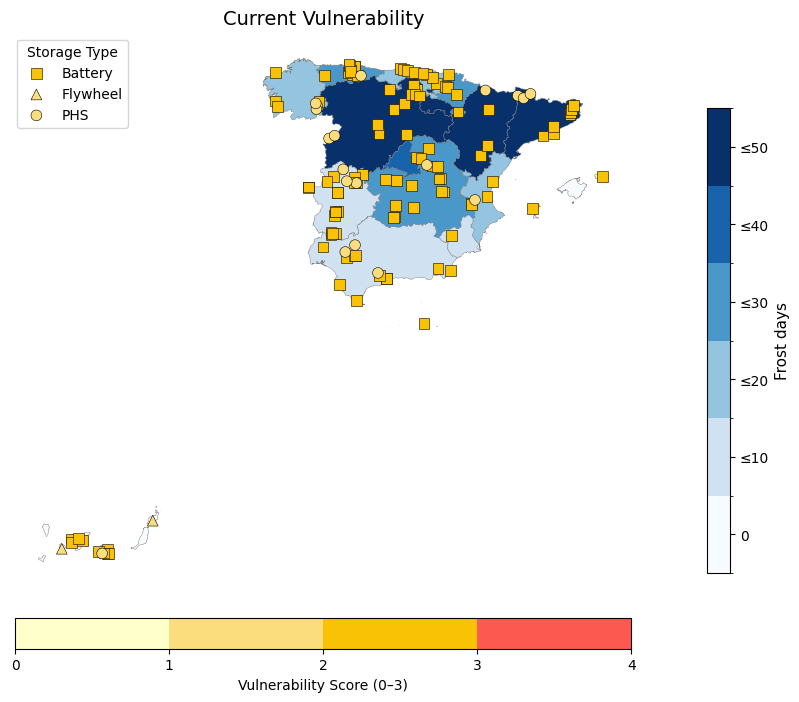

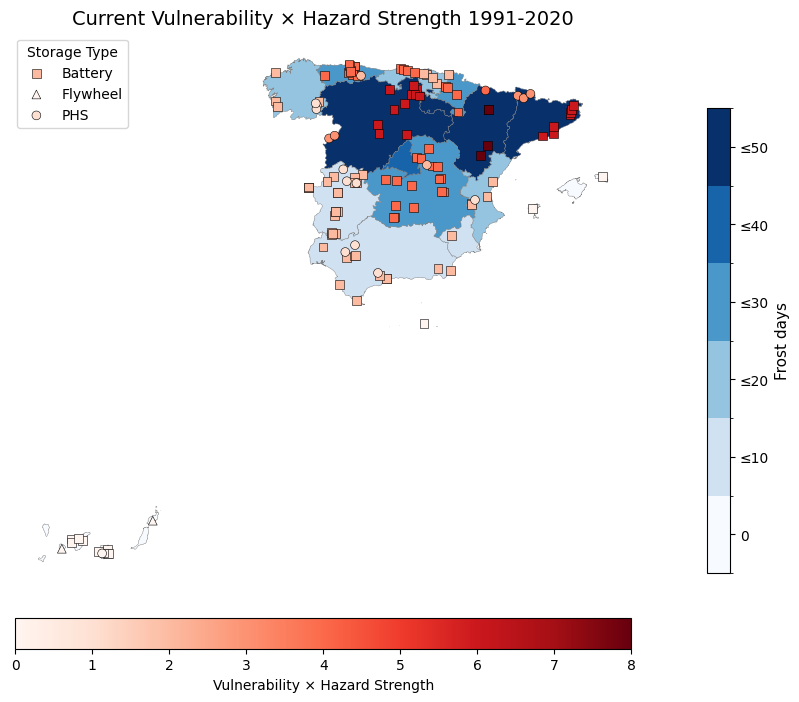

In [35]:
#CURRENT VULNERABILITY

# =========================
# Configuration
# =========================
# Ensure HOTDAYSCURRENT_COL and other necessary config variables are defined
REGION_COL = "Region"
ASSET_TYPE_COL = "Storage type"
VULN_COL = "Vulnerability frost days"
HAZARDCURRENT_COL = "Frost days 1991-2020 hazard strength"
FROSTDAYSCURRENT_COL = "Frost days 1991-2020"


# =========================================================
# REGION-LEVEL BACKGROUND
# =========================================================

# -------------------------------
# 1. Bin function (define FIRST)
# -------------------------------
def apply_leq_bins(df, col):
    df = df.copy()

    bins = [0, 1, 10, 20, 30, 40, 50]
    labels = ["0", "≤10", "≤20", "≤30", "≤40", "≤50"]

    df[col + "_binned"] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=True
    )

    return df


# -------------------------------
# 2. Create region background ONLY from regions
# -------------------------------
regions_bg = regions.copy()

regions_bg[FROSTDAYSCURRENT_COL] = regions_bg["NAME_1"].map(
    frost_days_present_dict
)

# -------------------------------
# 3. Apply binning to ALL regions
# -------------------------------
regions_bg = apply_leq_bins(regions_bg, FROSTDAYSCURRENT_COL)


# -------------------------------
# SAFE helper to get sorted category list for legend
# -------------------------------
def sorted_category_list(cat_series):
    # convert to strings, dropna, unique, try to sort by numeric if possible
    cats = [str(x) for x in pd.Series(cat_series.unique()).dropna()]
    try:
        # attempt to extract numeric start for ordering, fallback to lexicographic
        cats_sorted = sorted(cats, key=lambda s: float(s.replace('≤','').split('–')[0]))
    except Exception:
        cats_sorted = sorted(cats)
    return cats_sorted

# =========================================================
# DISCRETE VULNERABILITY COLOURS (0,1,2,3)
# =========================================================
vuln_colors = ["#FFFFCB", "#FBDD7E", "#FAC205", "#FC5A50"]
vuln_cmap = mcolors.ListedColormap(vuln_colors)
vuln_norm = mcolors.BoundaryNorm([0,1,2,3,4], vuln_cmap.N)


# -------------------------------
# Plotting functions using regions_bg
# -------------------------------
def plot_current_optionA(bg_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Use the pre-built regions_bg that contains the _binned column
    merged = regions_bg

    # Ensure the column exists on merged
    binned_col = bg_col + "_binned"
    if binned_col not in merged.columns:
        raise KeyError(f"{binned_col} not found in regions_bg — check you ran apply_leq_bins on data first")

    # categories present in the polygon GeoDataFrame (sorted)
    categories = sorted_category_list(merged[binned_col])

    # build discrete colormap
    cmap_bg = matplotlib.colormaps.get_cmap("Blues").resampled(len(categories)) # FIX: Use .resampled()
    bounds = np.arange(len(categories) + 1)
    norm_bg = mcolors.BoundaryNorm(bounds, cmap_bg.N)

    # Plot polygons (categorical)
    merged.plot(
        column=binned_col,
        cmap=cmap_bg,
        norm=norm_bg,
        ax=ax,
        edgecolor="grey",
        linewidth=0.3,
        legend=False
    )

    # Background colourbar
    sm = plt.cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=bounds[:-1] + 0.5, fraction=0.03, pad=0.02)
    cbar.set_ticklabels(categories)
    cbar.set_label("Frost days", fontsize=11)

    # Storage markers
    markers = {'Battery': 's', 'Flywheel': '^', 'PHS': 'o'}
    for t, marker in markers.items():
        subset = data[data[ASSET_TYPE_COL] == t]
        ax.scatter(
            subset["lon"], subset["lat"],
            c=subset[VULN_COL].astype(float),
            cmap=vuln_cmap,
            norm=vuln_norm,
            marker=marker,
            s=60,
            edgecolor="black",
            linewidth=0.4,
            label=t
        )

    # Vulnerability colourbar
    sm_v = plt.cm.ScalarMappable(cmap=vuln_cmap, norm=vuln_norm)
    plt.colorbar(sm_v, ax=ax, orientation="horizontal", fraction=0.05, pad=0.05).set_label("Vulnerability Score (0–3)")

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


def plot_current_optionB(bg_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    merged = regions_bg

    binned_col = bg_col + "_binned"
    if binned_col not in merged.columns:
        raise KeyError(f"{binned_col} not found in regions_bg — check you ran apply_leq_bins on data first")

    categories = sorted_category_list(merged[binned_col])

    cmap_bg = matplotlib.colormaps.get_cmap("Blues").resampled(len(categories)) # FIX: Use .resampled()
    bounds = np.arange(len(categories) + 1)
    norm_bg = mcolors.BoundaryNorm(bounds, cmap_bg.N)

    merged.plot(column=binned_col, cmap=cmap_bg, norm=norm_bg, ax=ax, edgecolor="grey", linewidth=0.3)

    sm = plt.cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=bounds[:-1] + 0.5, fraction=0.03, pad=0.02)
    cbar.set_ticklabels(categories)
    cbar.set_label("Frost days", fontsize=11)

    # compute VulnHazard_current if not already present
    if "VulnHazard_current" not in data.columns:
        data["VulnHazard_current"] = data[VULN_COL].astype(float) * data[HAZARDCURRENT_COL].astype(float)

    vals = data["VulnHazard_current"]
    norm_pts = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())

    markers = {"Battery": "s", "Flywheel": "^", "PHS": "o"}
    for t, marker in markers.items():
        subset = data[data[ASSET_TYPE_COL] == t]
        ax.scatter(
            subset["lon"], subset["lat"],
            c=subset["VulnHazard_current"].astype(float),
            cmap="Reds",
            norm=norm_pts,
            marker=marker,
            s=40,
            edgecolor="black",
            linewidth=0.4,
            label=t
        )

    sm_pts = plt.cm.ScalarMappable(cmap="Reds", norm=norm_pts)
    plt.colorbar(sm_pts, ax=ax, orientation="horizontal", fraction=0.05, pad=0.05).set_label("Vulnerability × Hazard Strength")

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()

plot_current_optionA(
    bg_col=FROSTDAYSCURRENT_COL,
    title="Current Vulnerability"
)

plot_current_optionB(
    bg_col=FROSTDAYSCURRENT_COL,
    title="Current Vulnerability × Hazard Strength 1991-2020"
)


In [36]:
data.loc[data['Region']=="Aragón", ['Storage type', VULN_COL, HAZARDCURRENT_COL, FROSTDAYSCURRENT_COL]]

,Storage type,Vulnerability frost days,Frost days 1991-2020 hazard strength,Frost days 1991-2020
32,Battery,2,4,47.51
33,Battery,2,4,47.51
34,Battery,2,4,47.51
35,Battery,2,4,47.51
36,PHS,1,4,47.51


In [38]:
# =========================================================
# ASSESSING POTENTIAL IMPACTS OF CLIMATE CHANGE  ON STORAGE PROJECTS (HOT DAYS >35C)
# =========================================================
# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
REGION_COL = "Region"
ASSET_TYPE_COL = "Storage type"
VULN_COL = "Vulnerability frost days"

FROSTDAYS_CHANGE45 = "Frost days change RCP4.5"
FROSTDAYS_CHANGE85 = "Frost days change RCP8.5"
HAZARDCURRENT_COL = "Frost days 1991-2020 hazard strength"

# =========================================================
# REGION-LEVEL BACKGROUND
# =========================================================
# 1. Bin function (define FIRST)
change_bins = [-float("inf"), -10, -5, 0, float("inf")]
change_labels = ["-10 to -6", "-5 to -1", "0"]

def bin_change(df, col):
    df[col + "_binned"] = pd.cut(
        df[col],
        bins=change_bins,
        labels=change_labels,
        include_lowest=True,
        right=True
    )
    return df

#Create region background from regions

regions_bg = regions.copy()

regions_bg[FROSTDAYS_CHANGE45] = regions_bg["NAME_1"].map(
    frost_days_change45_dict
)
regions_bg[FROSTDAYS_CHANGE85] = regions_bg["NAME_1"].map(
    frost_days_change85_dict
)

#Apply binning to ALL regions
regions_bg = bin_change(regions_bg, FROSTDAYS_CHANGE45)
regions_bg = bin_change(regions_bg, FROSTDAYS_CHANGE85)

# =========================================================
# 2. Colour map
# =========================================================
num_cats = len(change_labels)
import matplotlib
cmap_bg = matplotlib.colormaps.get_cmap("YlOrRd").resampled(num_cats)
norm_bg = mcolors.BoundaryNorm(np.arange(num_cats + 1), num_cats)


# =========================================================
# 3. Discrete vulnerability colormap (unchanged)
# =========================================================
vuln_colors = ["#FFFFCB", "#FBDD7E", "#FAC205", "#FC5A50"]
vuln_cmap = mcolors.ListedColormap(vuln_colors)
vuln_norm = mcolors.BoundaryNorm([0,1,2,3,4], vuln_cmap.N)


# =========================================================
# Function for both Option A & B
# =========================================================
def plot_step5(bg_col, title, color_points_by, cmap_points, norm_points):

    fig, ax = plt.subplots(figsize=(10, 8))

    merged = regions_bg

    # Plot background
    merged.plot(
        column=bg_col + "_binned",
        cmap=cmap_bg,
        norm=norm_bg,
        edgecolor="grey",
        linewidth=0.2,
        ax=ax,
        legend=False
    )

    # Colorbar for background
    sm_bg = plt.cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm_bg.set_array([])
    cbar = plt.colorbar(
        sm_bg, ax=ax,
        ticks=np.arange(num_cats) + 0.5,
        fraction=0.03, pad=0.02
    )
    cbar.set_ticklabels(change_labels)
    cbar.set_label("Change in frost days", fontsize=11)

    # Plot storage assets
    markers = {"Battery": "s", "Flywheel": "^", "PHS": "o"}

    for t, marker in markers.items():
        subset = data[data[ASSET_TYPE_COL] == t]
        ax.scatter(
            subset["lon"], subset["lat"],
            c=subset[color_points_by],
            cmap=cmap_points,
            norm=norm_points,
            marker=marker,
            s=40,
            edgecolor="black",
            linewidth=0.4,
            label=t
        )

    # Colorbar for points
    sm_pts = plt.cm.ScalarMappable(cmap=cmap_points, norm=norm_points)
    cbar2 = plt.colorbar(
        sm_pts, ax=ax, orientation="horizontal",
        fraction=0.05, pad=0.05
    )
    cbar2.set_label(title.split(":")[-1].strip(), fontsize=11)

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


# =========================================================
# 4. OPTION A — Vulnerability
# =========================================================
def plot_step5_optionA(bg_col, title):
    plot_step5(
        bg_col,
        title,
        color_points_by=VULN_COL,
        cmap_points=vuln_cmap,
        norm_points=vuln_norm
    )


# =========================================================
# 5. OPTION B — Vulnerability × HazardStrengthCurrent
# =========================================================
data["VulnHazard_current"] = (
    data[VULN_COL].astype(float) *
    data[HAZARDCURRENT_COL].astype(float)
)

def plot_step5_optionB(bg_col, title):
    vals = data["VulnHazard_current"]
    norm_pts = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())

    plot_step5(
        bg_col,
        title,
        color_points_by="VulnHazard_current",
        cmap_points="Reds",
        norm_points=norm_pts
    )


# =========================================================
# 6. GENERATE ALL MAPS
# =========================================================

plot_step5_optionA(
    FROSTDAYS_CHANGE45,
    "Vulnerability & Change in Frost Days (Present → RCP4.5)"
)

plot_step5_optionA(
    FROSTDAYS_CHANGE85,
    "Vulnerability & Change in Frost Days (Present → RCP8.5)"
)
#I don't think I need these
plot_step5_optionB(
    FROSTDAYS_CHANGE45,
    "Vulnerability × Hazard (Present → RCP4.5)"
)

plot_step5_optionB(
    FROSTDAYS_CHANGE85,
    "Vulnerability × Hazard (Present → RCP8.5)"
)


ValueError: Bin labels must be one fewer than the number of bin edges

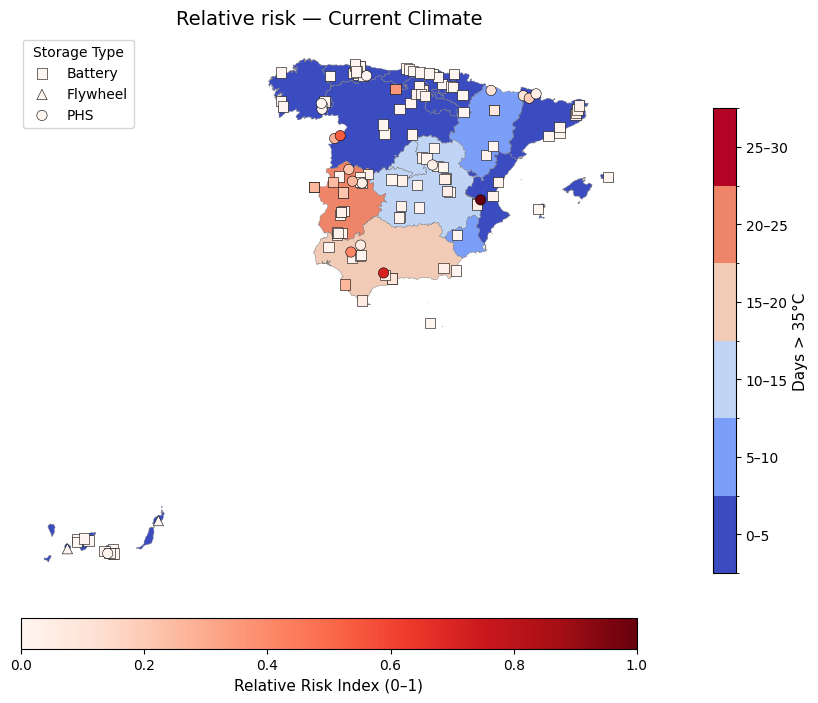

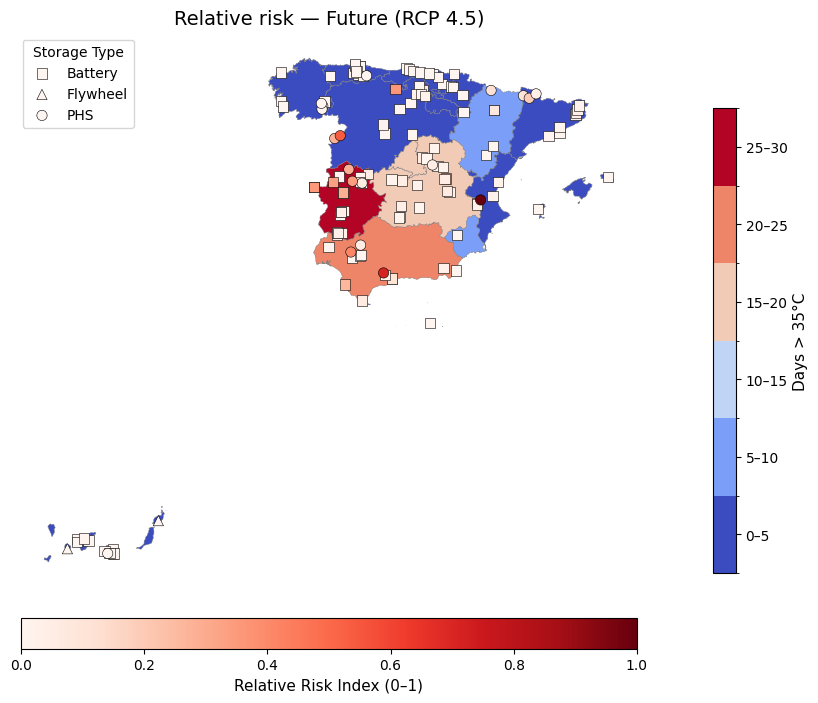

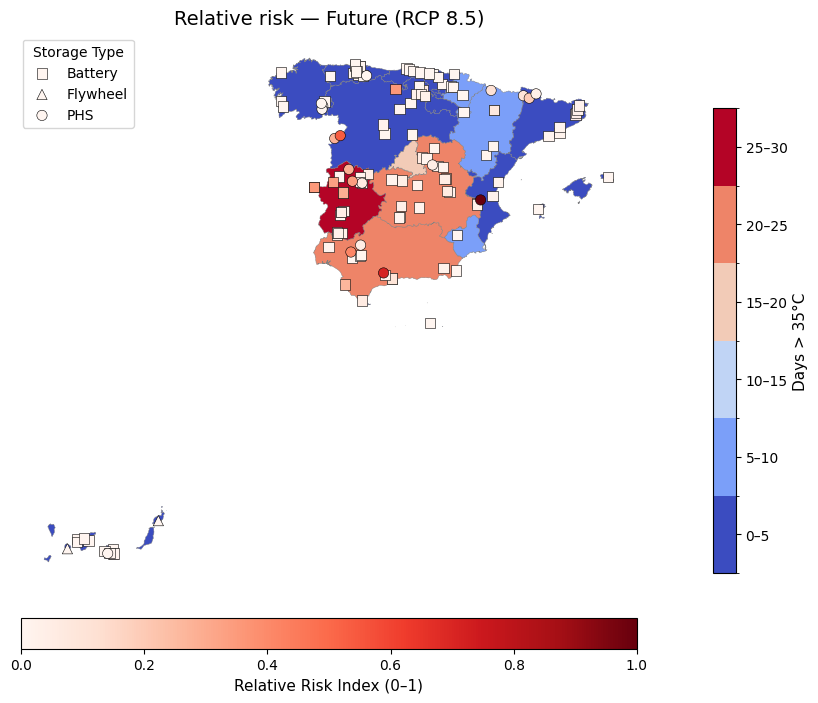

In [ ]:
#RELATIVE RISK
# =========================================================
# CONFIG
# =========================================================
REGION_COL = "Region"
ASSET_TYPE_COL = "Storage type"
CAPACITY_COL = "Capacity (MWh)"
POWER_COL = "Power (MW)"
IMPORTANCE_COL = "Importance score"
VULN_COL = "Vulnerability frost days"

HAZARDCURRENT_COL = "Frost days 1991-2020 hazard strength"
HAZARD45_COL     = "Frost days 2011-2040 hazard strength RCP4.5"
HAZARD85_COL     = "Frost days 2011-2040 hazard strength RCP8.5"

FROSTDAYSCURRENT_COL = "Frost days 1991-2020"
FROSTDAYS45_COL      = "Frost days 2011-2040 RCP4.5"
FROSTDAYS85_COL      = "Frost days 2011-2040 RCP8.5"

# =========================================================
# REGION-LEVEL BACKGROUND
# =========================================================
# 1. Bin function

bins = [0, 1, 10, 20, 30, 40, 50]
labels = ["0", "1-10", "10–20", "20–30", "30–40", "40–50"]

def apply_fixed_bins(df, col):
    df[col + "_binned"] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=False
    )
    return df

#Create region background from regions

regions_bg = regions.copy()

# Map current and future hot days data to regions_bg
regions_bg[FROSTDAYSCURRENT_COL] = regions_bg["NAME_1"].map(
    frost_days_present_dict
)
regions_bg[FROSTDAYS45_COL] = regions_bg["NAME_1"].map(
    frost_days_future45_dict
)
regions_bg[FROSTDAYS85_COL] = regions_bg["NAME_1"].map(
    frost_days_future85_dict
)

#Apply binning to ALL regions
regions_bg = apply_fixed_bins(regions_bg, FROSTDAYSCURRENT_COL)
regions_bg = apply_fixed_bins(regions_bg, FROSTDAYS45_COL)
regions_bg = apply_fixed_bins(regions_bg, FROSTDAYS85_COL)

# =========================================================
# 1. Choose exposure measure (MWh > MW > count)
# =========================================================
def choose_exposure(row):
    if pd.notna(row.get(CAPACITY_COL)):
        return float(row[CAPACITY_COL])
    if pd.notna(row.get(POWER_COL)):
        return float(row[POWER_COL])
    return 1.0

data["Exposure"] = data.apply(choose_exposure, axis=1)


# =========================================================
# 2. Compute raw risk per asset (IPCC: hazard × vulnerability × exposure)
# =========================================================
data["Riskcurrent_raw"] = (
    data[HAZARDCURRENT_COL].astype(float) *
    data[VULN_COL].astype(float) *
    data["Exposure"].astype(float)
)

data["Risk45_raw"] = (
    data[HAZARD45_COL].astype(float) *
    data[VULN_COL].astype(float) *
    data["Exposure"].astype(float)
)

data["Risk85_raw"] = (
    data[HAZARD85_COL].astype(float) *
    data[VULN_COL].astype(float) *
    data["Exposure"].astype(float)
)


# =========================================================
# 3. Normalise asset-level risks (0–1)
# =========================================================
def normalize(s):
    vmin, vmax = s.min(), s.max()
    if vmax == vmin:
        return pd.Series(0, index=s.index)
    return (s - vmin) / (vmax - vmin)

data["Riskcurrent_norm"] = normalize(data["Riskcurrent_raw"])
data["Risk45_norm"]      = normalize(data["Risk45_raw"])
data["Risk85_norm"]      = normalize(data["Risk85_raw"])


# =========================================================
# 4. REGIONAL risk index (sum of asset risks per region)
# =========================================================
region_risk = (
    data.groupby(REGION_COL)[["Riskcurrent_raw", "Risk45_raw", "Risk85_raw"]]
    .sum()
    .reset_index()
)

region_risk["Riskcurrent_region_norm"] = normalize(region_risk["Riskcurrent_raw"])
region_risk["Risk45_region_norm"]      = normalize(region_risk["Risk45_raw"])
region_risk["Risk85_region_norm"]      = normalize(region_risk["Risk85_raw"])


# =========================================================
# 5. Create GeoDataFrame for assets
# =========================================================
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["lon"], data["lat"]),
    crs="EPSG:4326"
)


# =========================================================
# 7. MAP FUNCTION (consistent colorbars + separate point risk)
# =========================================================

def plot_risk_map(bg_col, point_col, title):

    fig, ax = plt.subplots(figsize=(10, 8))

    # Merge background values with region polygons
    background = regions_bg

    # Background plot using binned hot days
    background.plot(
        column=bg_col + "_binned",
        cmap="Blues",
        linewidth=0.3,
        edgecolor="grey",
        ax=ax,
        legend=False
    )

    # --- Updated categorical colormap ---
    import matplotlib
    cmap_bg = matplotlib.colormaps.get_cmap("Blues").resampled(len(labels))

    norm_bg = mcolors.BoundaryNorm(
        boundaries=np.arange(0, len(labels) + 1),
        ncolors=len(labels)
    )

    sm_bg = cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm_bg.set_array([])

    cbar1 = fig.colorbar(
        sm_bg, ax=ax, fraction=0.03, pad=0.02, shrink=0.8,
        ticks=np.arange(len(labels)) + 0.5
    )
    cbar1.set_ticklabels(labels)
    cbar1.set_label("Days > 35°C", fontsize=11)

    # --- Points (asset relative risk) ---
    vals = points[point_col].astype(float)
    norm = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())

    markers = {"Battery": "s", "Flywheel": "^", "PHS": "o",}

    for stype, marker in markers.items():
        subset = points[points[ASSET_TYPE_COL] == stype]
        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            c=subset[point_col],
            cmap="Reds",
            norm=norm,
            marker=marker,
            s=55,
            edgecolor="black",
            linewidth=0.4,
            zorder=5,
            label=stype
        )

    # Point colorbar
    sm_pts = cm.ScalarMappable(cmap="Reds", norm=norm)
    fig.colorbar(sm_pts, ax=ax, orientation="horizontal",
                 fraction=0.05, pad=0.05
    ).set_label("Relative Risk Index (0–1)", fontsize=11)

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()



# =========================================================
# 8. GENERATE MAPS
# =========================================================

# Current climate
plot_risk_map(
    bg_col=FROSTDAYSCURRENT_COL,
    point_col="Riskcurrent_norm",
    title="Relative risk — Current Climate"
)

# RCP4.5
plot_risk_map(
    bg_col=FROSTDAYS45_COL,
    point_col="Risk45_norm",
    title="Relative risk — Future (RCP 4.5)"
)

# RCP8.5
plot_risk_map(
    bg_col=FROSTDAYS85_COL,
    point_col="Risk85_norm",
    title="Relative risk — Future (RCP 8.5)"
)


/tmp/ipython-input-4275643216.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


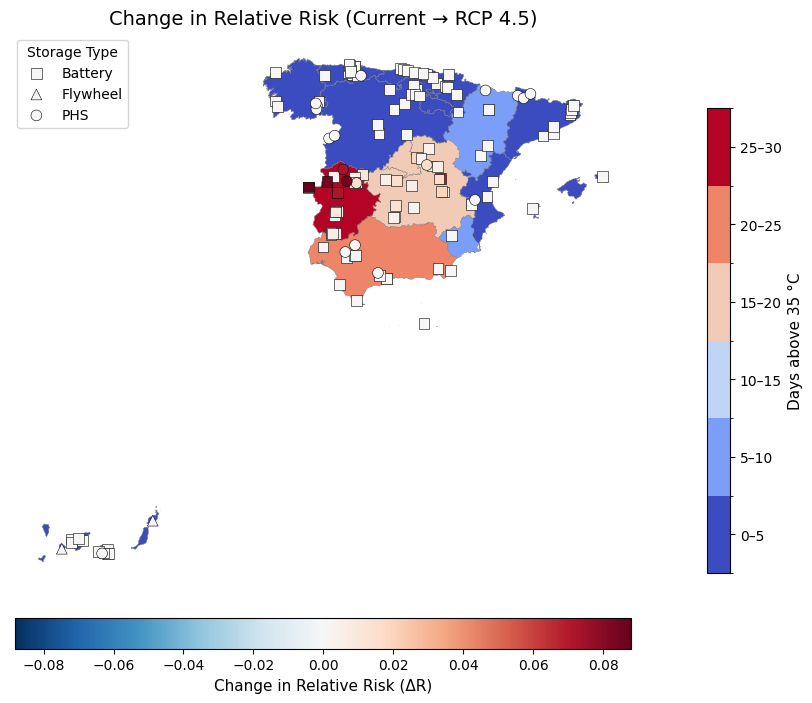

/tmp/ipython-input-4275643216.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


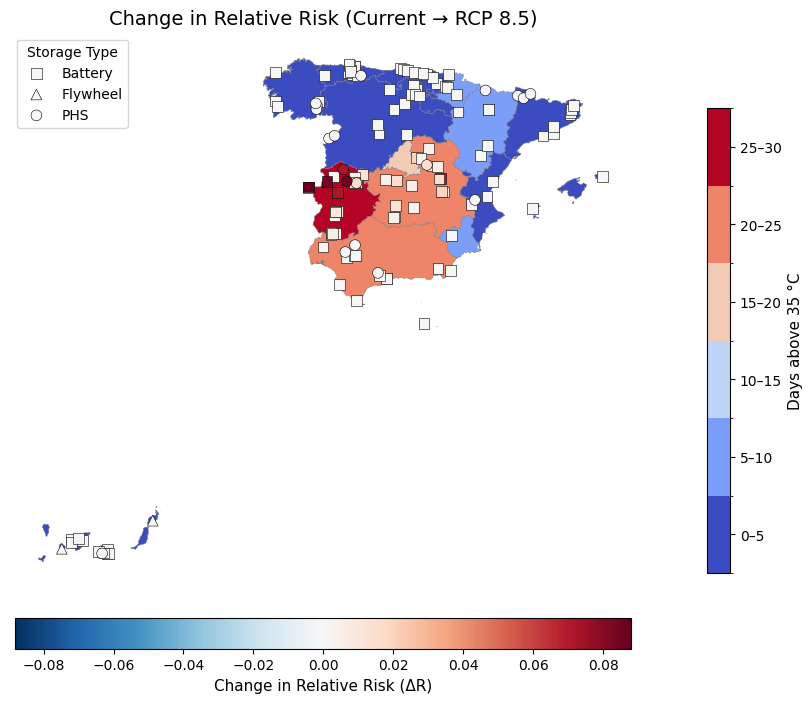

/tmp/ipython-input-4275643216.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(labels))


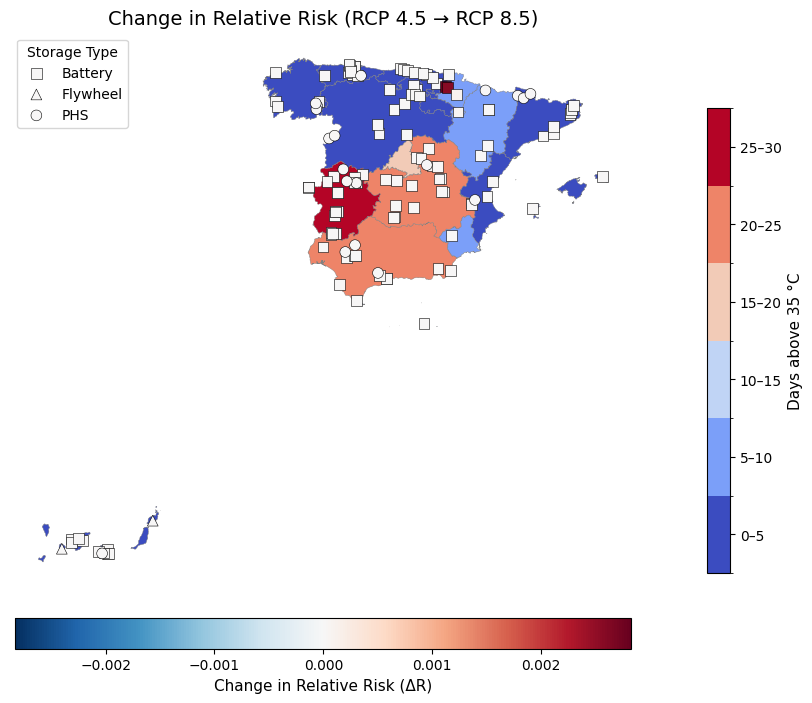

In [ ]:
#CHANGES IN RELATIVE RISK
# =========================================================
# 1. COMPUTE DIFFERENCES BETWEEN SCENARIOS
# =========================================================

points["Delta_current_45"] = points["Risk45_norm"] - points["Riskcurrent_norm"]
points["Delta_current_85"] = points["Risk85_norm"] - points["Riskcurrent_norm"]
points["Delta_45_85"]      = points["Risk85_norm"] - points["Risk45_norm"]

# =========================================================
# REGION-LEVEL BACKGROUND
# =========================================================
# 1. Bin function

bins = [0, 1, 10, 20, 30, 40, 50]
labels = ["0", "1-10", "10–20", "20–30", "30–40", "40–50"]

def apply_fixed_bins(df, col):
    df[col + "_binned"] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=False
    )
    return df

#Create region background from regions

regions_bg = regions.copy()

# Map current and future hot days data to regions_bg
regions_bg[FROSTDAYSCURRENT_COL] = regions_bg["NAME_1"].map(
    frost_days_present_dict
)
regions_bg[FROSTDAYS45_COL] = regions_bg["NAME_1"].map(
    frost_days_future45_dict
)
regions_bg[FROSTDAYS85_COL] = regions_bg["NAME_1"].map(
    frost_days_future85_dict
)

#Apply binning to ALL regions
regions_bg = apply_fixed_bins(regions_bg, FROSTDAYS45_COL)
regions_bg = apply_fixed_bins(regions_bg, FROSTDAYS85_COL)

# =========================================================
# 2. NEW PLOT FUNCTION FOR CHANGE MAPS
# =========================================================

def plot_change_map(bg_col, delta_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Background layer (same hot-day bins)
    background = regions_bg

    background.plot(
        column=bg_col + "_binned",
        cmap="Blues",
        linewidth=0.3,
        edgecolor="grey",
        ax=ax,
        legend=False
    )

    # Background colorbar (same bins for all maps)
    labels = ["0","1–10","10–20","20–30","30–40","40–50"]
    cmap_bg = cm.get_cmap("Blues", len(labels))
    norm_bg = mcolors.BoundaryNorm(range(len(labels)+1), cmap_bg.N)

    sm_bg = cm.ScalarMappable(cmap=cmap_bg, norm=norm_bg)
    sm_bg.set_array([])

    cbar1 = fig.colorbar(
        sm_bg, ax=ax, fraction=0.03, pad=0.02, shrink=0.8,
        ticks=np.arange(len(labels)) + 0.5
    )
    cbar1.set_ticklabels(labels)
    cbar1.set_label("Frost days", fontsize=11)

    # ---------------------------------------
    # POINTS (risk change: diverging colormap)
    vals = points[delta_col].astype(float)
    absmax = max(abs(vals.min()), abs(vals.max()))
    norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-absmax, vmax=absmax)

    for stype, marker in {"Battery":"s","Flywheel":"^", "PHS": "o",}.items():
        subset = points[points[ASSET_TYPE_COL] == stype]

        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            c=subset[delta_col],
            cmap="RdBu_r",
            norm=norm,
            marker=marker,
            s=60,
            edgecolor="black",
            linewidth=0.4,
            zorder=5,
            label=stype
        )

    # Point colorbar (risk change)
    sm_pts = cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    cbar2 = fig.colorbar(
        sm_pts, ax=ax, orientation="horizontal",
        fraction=0.05, pad=0.05
    )
    cbar2.set_label("Change in Relative Risk (ΔR)", fontsize=11)

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


# =========================================================
# 3. PLOT CHANGE MAPS
# =========================================================

# Current → RCP4.5
plot_change_map(
    bg_col=FROSTDAYS45_COL,
    delta_col="Delta_current_45",
    title="Change in Relative Risk (Current → RCP 4.5)"
)

# Current → RCP8.5
plot_change_map(
    bg_col=FROSTDAYS85_COL,
    delta_col="Delta_current_85",
    title="Change in Relative Risk (Current → RCP 8.5)"
)

# RCP4.5 → RCP8.5
plot_change_map(
    bg_col=FROSTDAYS85_COL,
    delta_col="Delta_45_85",
    title="Change in Relative Risk (RCP 4.5 → RCP 8.5)"
)


/tmp/ipython-input-2375170131.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


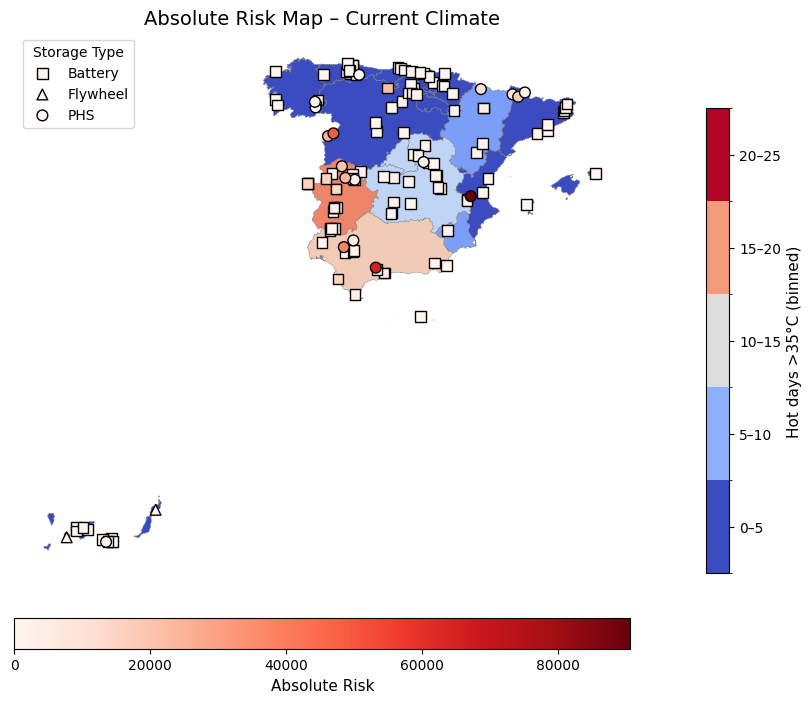

/tmp/ipython-input-2375170131.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


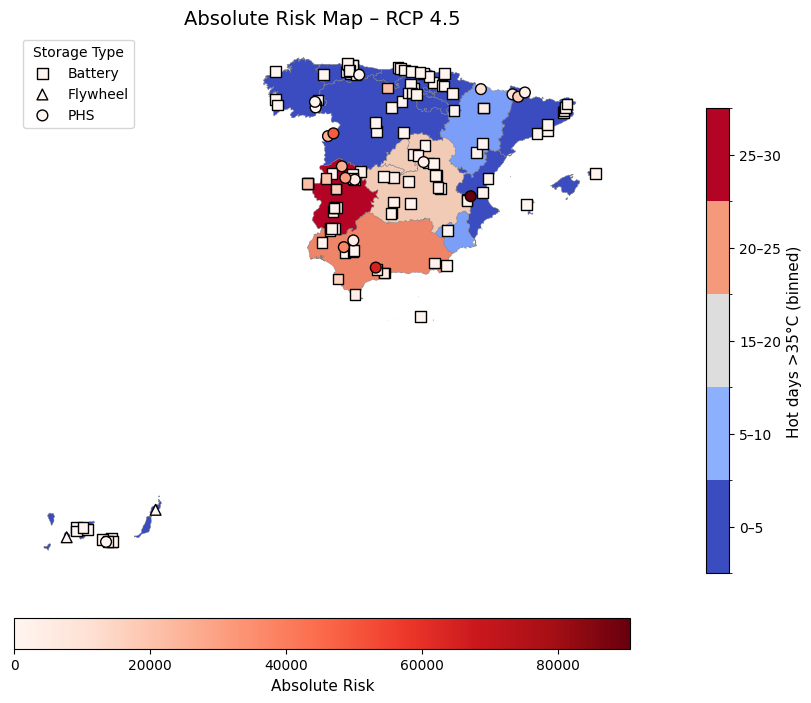

/tmp/ipython-input-2375170131.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


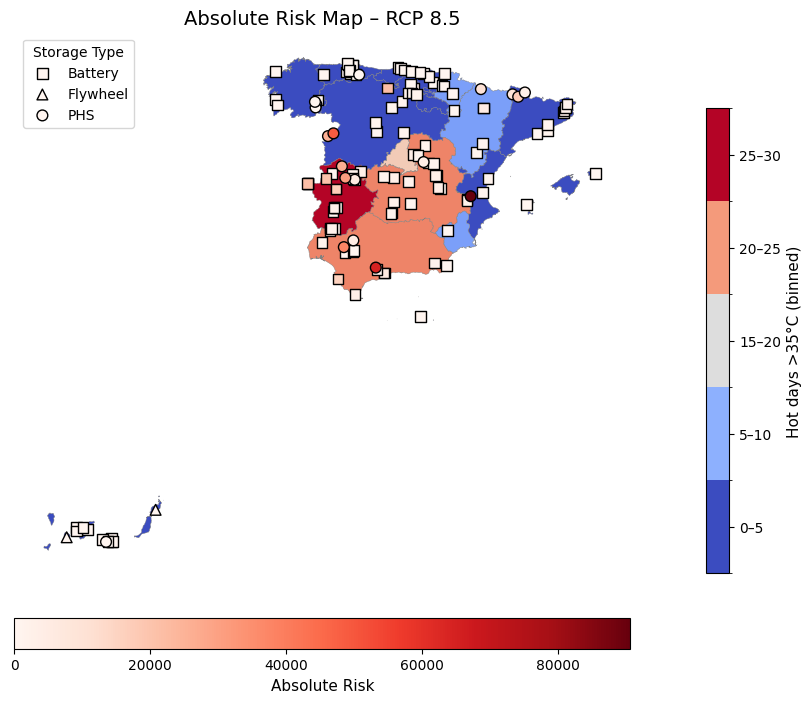

/tmp/ipython-input-2375170131.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


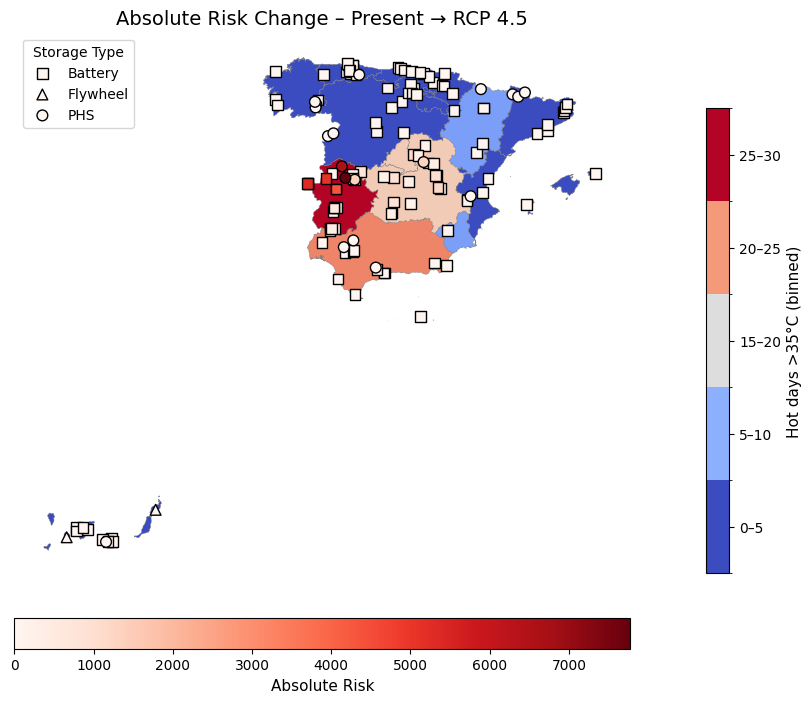

/tmp/ipython-input-2375170131.py:144: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_bg = cm.get_cmap("coolwarm", len(categories))


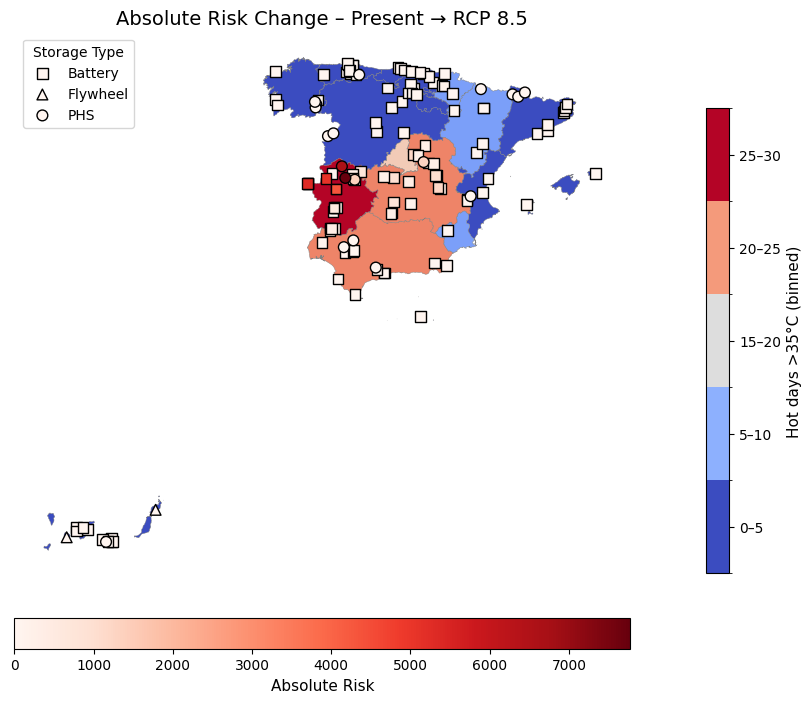

In [ ]:
#ABSOLUTE RISK MAPS
# ============================================
# CONFIG
# ============================================
REGION_COL = "Region"
TYPE_COL = "Storage type"
CAPACITY_COL = "Capacity (MWh)"
POWER_COL = "Power (MW)"
IMPORTANCE_COL = "Importance score"
VULN_COL = "Vulnerability frost days >35C"

HAZARDCURRENT_COL = "Frost days 1991-2020 hazard strength"
HAZARD45_COL = "Frost days 2011-2040 hazard strength RCP4.5"
HAZARD85_COL = "Frost days 2011-2040 hazard strength RCP8.5"

FROSTDAYSCURRENT_COL = "Frost days 1991-2020"
FROSTDAYS45_COL = "Frost days 2011-2040 RCP4.5"
FROSTDAYS85_COL = "Frost days 2011-2040 RCP8.5"

# =========================================================
# REGION-LEVEL BACKGROUND
# =========================================================
# 1. Bin function

bins = [0, 1, 10, 20, 30, 40, 50]
labels = ["0", "1–10", "10–20", "20–30", "30–40", "40–50"]

def apply_fixed_bins(df, col):
    df[col + "_binned"] = pd.cut(
        df[col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=False
    )
    return df

#Create region background from regions

regions_bg = regions.copy()

# Map current and future hot days data to regions_bg
regions_bg[FROSTDAYSCURRENT_COL] = regions_bg["NAME_1"].map(
    frost_days_present_dict
)
regions_bg[FROSTDAYS45_COL] = regions_bg["NAME_1"].map(
    frost_days_future45_dict
)
regions_bg[FROSTDAYS85_COL] = regions_bg["NAME_1"].map(
    frost_days_future85_dict
)

#Apply binning to ALL regions
regions_bg = apply_fixed_bins(regions_bg, FROSTDAYSCURRENT_COL)
regions_bg = apply_fixed_bins(regions_bg, FROSTDAYS45_COL)
regions_bg = apply_fixed_bins(regions_bg, FROSTDAYS85_COL)

# ============================================
# 1. EXPOSURE SELECTION (MWh > MW > 1)
# ============================================
def choose_exposure(row):
    if pd.notna(row.get(CAPACITY_COL)):
        return float(row[CAPACITY_COL])
    if pd.notna(row.get(POWER_COL)):
        return float(row[POWER_COL])
    return 1.0

data["Exposure"] = data.apply(choose_exposure, axis=1)

# ============================================
# 2. ABSOLUTE RISK CALCULATION
# ============================================
# Risk = Hazard × Vulnerability × Exposure × Importance

data["Risk_current_abs"] = (
    data[HAZARDCURRENT_COL].astype(float)
    * data[VULN_COL].astype(float)
    * data["Exposure"].astype(float)
    * data[IMPORTANCE_COL].astype(float)
)

data["Risk_45_abs"] = (
    data[HAZARD45_COL].astype(float)
    * data[VULN_COL].astype(float)
    * data["Exposure"].astype(float)
    * data[IMPORTANCE_COL].astype(float)
)

data["Risk_85_abs"] = (
    data[HAZARD85_COL].astype(float)
    * data[VULN_COL].astype(float)
    * data["Exposure"].astype(float)
    * data[IMPORTANCE_COL].astype(float)
)

# ============================================
# 3. ABSOLUTE RISK CHANGE
# ============================================
data["Risk_change_45"] = data["Risk_45_abs"] - data["Risk_current_abs"]
data["Risk_change_85"] = data["Risk_85_abs"] - data["Risk_current_abs"]

# ============================================
# 4. Create GeoDataFrame for POINTS
# ============================================
points = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["lon"], data["lat"]),
    crs="EPSG:4326"
)


# ============================================
# 6. PLOTTING FUNCTION FOR ABSOLUTE RISK MAPS
# ============================================
def plot_absolute_risk(bg_col, risk_col, title):
    fig, ax = plt.subplots(figsize=(10, 8))

    # ---- Background map using HOT-DAY bins ----
    background = regions_bg

    background.plot(
        column=bg_col + "_binned",
        cmap="Blues",
        linewidth=0.3,
        edgecolor="grey",
        ax=ax,
        legend=False
    )

    # Custom legend for background bins
    categories = regions_bg[bg_col + "_binned"].dropna().unique().tolist()
    categories.sort(key=lambda c: float(c.split("–")[0]) if "–" in c else 99)
    cmap_bg = cm.get_cmap("Blues", len(categories))
    sm_bg = cm.ScalarMappable(
        cmap=cmap_bg,
        norm=mcolors.BoundaryNorm(range(len(categories)+1), cmap_bg.N)
    )
    cbar1 = fig.colorbar(sm_bg, ax=ax, fraction=0.03, pad=0.02, shrink=0.8)
    cbar1.set_ticks(np.arange(len(categories)) + 0.5)
    cbar1.set_ticklabels(categories)
    cbar1.set_label("Frost days", fontsize=11)

    # ---- Storage projects ----
    vals = points[risk_col].astype(float)
    norm = mcolors.Normalize(vmin=vals.min(), vmax=vals.max())

    markers = {"Battery": "s", "Flywheel": "^", "PHS": "o",}

    for t, marker in markers.items():
        subset = points[points[TYPE_COL] == t]
        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            c=subset[risk_col],
            cmap="Reds",
            norm=norm,
            marker=marker,
            s=60,
            edgecolor="black",
            zorder=5,
            label=t
        )

    sm_risk = cm.ScalarMappable(norm=norm, cmap="Reds")
    cbar2 = fig.colorbar(
        sm_risk, ax=ax, orientation="horizontal",
        fraction=0.05, pad=0.07
    )
    cbar2.set_label("Absolute Risk", fontsize=11)

    plt.title(title, fontsize=14)
    plt.legend(title="Storage Type")
    plt.axis("off")
    plt.show()


# ============================================
# 7. PLOT ABSOLUTE RISK MAPS
# ============================================

# ---- CURRENT ----
plot_absolute_risk(
    bg_col=HOT_CUR,
    risk_col="Risk_current_abs",
    title="Absolute Risk Map – Current Climate"
)

# ---- RCP 4.5 ----
plot_absolute_risk(
    bg_col=HOT_45,
    risk_col="Risk_45_abs",
    title="Absolute Risk Map – RCP 4.5"
)

# ---- RCP 8.5 ----
plot_absolute_risk(
    bg_col=HOT_85,
    risk_col="Risk_85_abs",
    title="Absolute Risk Map – RCP 8.5"
)

# ============================================
# 8. MAP RISK CHANGES
# ============================================

# ---- Change Present → RCP 4.5 ----
plot_absolute_risk(
    bg_col=HOT_45,
    risk_col="Risk_change_45",
    title="Absolute Risk Change – Present → RCP 4.5"
)

# ---- Change Present → RCP 8.5 ----
plot_absolute_risk(
    bg_col=HOT_85,
    risk_col="Risk_change_85",
    title="Absolute Risk Change – Present → RCP 8.5"
)


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

data